Based on linear model approach

# Imports, load data, set up labels, functions, etc.

In [24]:
import pandas as pd
import pickle
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn2_circles
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import re
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from scipy.stats import chi2_contingency
from numpy.random import randint
from numpy.random import shuffle
import math
import matplotlib.image as mpimg
import itertools
from matplotlib.patches import ConnectionPatch

import mygene
mg = mygene.MyGeneInfo()

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('seaborn-paper')
%config InlineBackend.figure_format = 'svg'


In [25]:
ne = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Ephys_Data/discovery_dataset.csv', index_col = 0)
celltypes = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Ephys_Data/journal.pcbi.1005814.s008.csv', index_col = 0)
celltype_dict = {a: b for a, b in zip(celltypes.celltype, celltypes['Major Type'])}
ne['Major_Type'] = [celltype_dict[type] for type in ne.celltype]
ne_inh = ne[(ne.Major_Type != 'Glutamatergic') & (ne.Major_Type != 'MSN') & (ne.Major_Type != 'Pyramidal') & (ne.celltype != 'Ctx Htr3a') & (ne.celltype != 'Ctx Oxtr')]


In [26]:
color_int = '#7B0192'
color_par = '#018484'
color_shared = '#FF6E62'
color_reg = '#DBD100'
color_exc = '#006DDB'
color_inh = '#920000'

In [27]:
# Load data from October 2018 analysis
outer_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/'
analysis_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/'
analysis_folder_morph = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-16/'

df_ephys = pd.read_csv(analysis_folder + 'ephys_mean.csv', index_col = 0)
df_seq = pd.read_csv(analysis_folder + 'seq_mean.csv', index_col = 0)
df_ephys_sem = pd.read_csv(analysis_folder + 'ephys_sem.csv', index_col = 0)

df_morph = pd.read_csv(analysis_folder_morph + 'morph_mean.csv', index_col = 0)
df_seq_morph = pd.read_csv(analysis_folder_morph + 'seq_mean.csv', index_col = 0)
df_morph_sem = pd.read_csv(analysis_folder_morph + 'morph_sem.csv', index_col = 0)

# Re-save as Tables S6, S7
property means per cell type, ephys & morphology respectively
ephys/morphology data combined with seq data from same analysis

In [73]:
# pd.concat([df_ephys, df_seq]).to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS6.csv')
# pd.concat([df_morph, df_seq_morph]).to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS7.csv')

In [28]:
res = pd.read_csv(analysis_folder + 'results_table.csv', index_col = 0)
res_morph = pd.read_csv(analysis_folder_morph + 'results_table.csv', index_col = 0)
res_morph.rename({'morph_measure' : 'ephys_measure'}, axis = 1, inplace = True)
res = pd.concat([res, res_morph], axis = 0)

In [29]:
# remove log10 labels from working copy to make plotting easier, but record for which log10 was used
measures_log10 = []
for m in list(set(res['ephys_measure'])):
    if m.endswith('_log10'):
        measures_log10.append(m)
res.ephys_measure = [m.replace('_log10', '') for m in res.ephys_measure]
measures_all = list(set(res['ephys_measure']))

In [30]:
# set order of measures

measures_all = ['rheo', 'apthr', 'aphw', 'apamp', 'ahpamp',
                'cap', 'tau', 'ri', 'rmp', 'sag',
                'avg_isi', 'isi_cv', 'latency', 'maxfreq', 'f_i_curve_slope', 'adratio', 
                'average_bifurcation_angle_local',
                'branchiness', 'max_branch_order', 'total_length',
                'total_volume', 'soma_surface']

In [31]:
# Load gene names & symbols

gene_info = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_genes-rows.csv', index_col = 3)

id_to_symbol = gene_info['gene_symbol'].to_dict()
id_to_name = gene_info['gene_name'].to_dict()

In [32]:
line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df_ephys.columns]
line_labels_morph = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df_morph.columns]

In [33]:
res_dict = {}

for measure in measures_all:
    res_dict[measure] = res[res.ephys_measure == measure]

In [34]:
measure_dict = {'apamp': 'AP Amplitude', 'ahpamp': 'AHP Amplitude', 'aphw': 'AP Half-width', 
                'maxfreq': 'Max Firing Frequency', 'tau' : 'Time Constant Tau', 'rmp': 'Resting Membrane Potential',
                'avg_isi': 'Average Interspike Interval', 'f_i_curve_slope': 'Input-Output Curve Slope',
                'cap' : 'Capacitance', 'sag': 'Sag', 'ri': 'Input Resistance', 'rheo': 'Rheobase',
                'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold', 
                'latency' : 'Latency', 'isi_cv' : 'ISI CoV', 
                'average_bifurcation_angle_local' : 'Bifurcation Angle', 'max_branch_order' : 'Max Branch Order', 
                'branchiness' : 'Branchiness', 'total_length' : 'Total Length',
                'total_volume' : 'Total Volume', 'soma_surface' : 'Soma Surface'}

measure_dict_units = {'apamp': 'AP Amplitude (mV)', 'ahpamp': 'AHP Amplitude (mV)', 'aphw': 'AP Half-width (ms)', 
                      'maxfreq': 'Max Firing\nFrequency (Hz)', 'maxfreq_log10': 'Max Firing\nFrequency (Hz)', 
                      'tau' : 'Time Constant Tau (ms)', 'rmp': 'Resting Membrane Potential (mV)',
                      'avg_isi': 'Average Interspike Interval (ms)', 'f_i_curve_slope': 'Input-Output Curve\nSlope (Hz/pA)',
                      'cap' : 'Capacitance (pF)', 'sag': 'Sag', 'ri': u'Input Resistance (MΩ)', 'rheo': 'Rheobase (pA)',
                      'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold (mV)', 
                      'latency' : 'Latency (s)', 'isi_cv' : 'ISI CoV', 
                      'average_bifurcation_angle_local' : 'Bifurcation Angle (degrees)', 'max_branch_order' : 'Max Branch Order', 
                      'branchiness' : u'Branchiness\n(branches/μm)', 'total_length' : u'Total Length (μm)',
                      'total_volume' : u'Total Volume (μm^3)', 'soma_surface' : u'Soma Surface (μm^2)'}



In [35]:
def calculate_overlap(ds, corrtypes, col_labels, measure_dict, alpha = 0.1):

    sig_dd = {}
    overlap_df = pd.DataFrame(columns = col_labels, index = [measure_dict[measure] for measure in ds.keys()])
    
    for measure in measures_all:
        sig_d = {}
        qvals = ds[measure]
        for n in range(len(corrtypes)):
            sig_d[corrtypes[n]] = qvals.gene_symbol[qvals[corrtypes[n]] < alpha].values
        sig_dd[measure] = sig_d
        in_1 = len(sig_d[corrtypes[0]])
        in_2 = len(sig_d[corrtypes[1]])
        both = len(set(sig_d[corrtypes[0]]).intersection(set(sig_d[corrtypes[1]])))
        overlap_df.loc[measure_dict[measure]] = [in_1, in_2, both]
        
    return overlap_df, sig_dd

In [36]:
def make_scatter(gene, measure, ax, df_seq, df_ephys, line_labels, zero_threshold = 2, alpha = 0.6, unit = 'CPM', s = 30, log = False):

    if log:
        ax.set_yscale('log')
        
    x = df_seq.loc[gene]        
    y = df_ephys.loc[measure]
    line_labels_gene = line_labels
    exc = [n > 0.5 for n in line_labels]
    inh = [n <= 0.5 for n in line_labels]

    not_zero = [val > 0 for val in x]
    if not_zero.count(False) >= zero_threshold:
        x = x[not_zero]
        y = y[not_zero]
        exc = [a and b for a, b in zip(exc, not_zero)]
        inh = [a and b for a, b in zip(inh, not_zero)]
        line_labels_gene = [i for (i, v) in zip(line_labels_gene, not_zero) if v]

    x_exc = df_seq.loc[:, exc].loc[gene]
    y_exc = df_ephys.loc[:, exc].loc[measure]    
    x_inh = df_seq.loc[:, inh].loc[gene]
    y_inh = df_ephys.loc[:, inh].loc[measure]    
    
    fit_all = np.polyfit(x, np.log10(y) if log else y, deg = 1)
    fit_exc = np.polyfit(x_exc, np.log10(y_exc) if log else y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, np.log10(y_inh) if log else y_inh, deg = 1)
    
    for x_subset, y_subset, color, marker in zip([x_inh, x_exc], [y_inh, y_exc], [color_inh, color_exc], ['o', 'D']):
        ax.scatter(x_subset, y_subset, color = color, s = s, marker = marker, alpha = alpha)

    lim_all = pd.Series([x.min(), x.max()])
    lim_exc = pd.Series([x_exc.min(), x_exc.max()])
    lim_inh = pd.Series([x_inh.min(), x_inh.max()])

    for lim, fit, linestyle in zip([lim_all, lim_exc, lim_inh], [fit_all, fit_exc, fit_inh], ['k--', 'k-', 'k-']):
        if log:
            fit_line = 10**(lim * fit[0] + fit[1])
        else:
            fit_line = lim * fit[0] + fit[1]
        ax.plot(lim, fit_line, linestyle, linewidth = 1)

    ax.set_xlabel(id_to_symbol[gene] + ' ($log_2$ ' + unit + '+1)')
    ax.set_ylabel(measure_dict_units[measure])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Fig 1
# Schematic of hypothetical genes showing partial/regular correlation only
# + methods

In [573]:
# # Generate "true" means for x and y variables
# # Simulate "class-driven" data

# means1 = np.random.multivariate_normal([50, 50], [[100, 0], [0, 100]], 16)
# add1 = np.concatenate([(np.tile([0, 0], (8, 1))), (np.tile([50, 50], (8, 1)))])
# means_df1 = pd.DataFrame(means1 + add1)


# # Generate "true" means for x and y variables
# # Simulate "non-class-driven" data

# means2 = np.random.multivariate_normal([100, 100], [[100, 98], [98, 100]], 16)
# add2 = np.concatenate([(np.tile([15, 0], (8, 1))), (np.tile([0, 30], (8, 1)))])
# means_df2 = pd.DataFrame(means2 + add2)


# # Generate "true" means for x and y variables
# # Simulate data with interaction
# means3 = np.random.multivariate_normal([100, 100], [[100, 95], [95, 100]], 8)
# means4 = np.random.multivariate_normal([100, 100], [[100, -95], [-95, 100]], 8)
# means_df3a = pd.DataFrame(means3)
# means_df3b = pd.DataFrame(means4)

# # Generate samples of individual cells based on "true" pop means

# points1 = []
# points2 = []
# points3a = []
# points3b = []

# for points, means_df, cov, sign in[[points1, means_df1, 0.00001, 1], [points2, means_df2, 0.0095, 1], 
#                                    [points3a, means_df3a, 0.0095, 1], [points3b, means_df3b, 0.0095, -1]]:

#     for mean in means_df.iterrows():
#         new_points = np.random.multivariate_normal([mean[1][0], mean[1][1]], 
#                                                    [[mean[1][0] * 0.01, mean[1][0] * cov * sign], [mean[1][1] * cov * sign, mean[1][1] * 0.01]], 10)
#         points.append(new_points)


# means_df3 = pd.concat([means_df3a, means_df3b])
# points3 = points3a + points3b

In [574]:
# Save simulated data

# means_df1.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df1.csv')
# means_df2.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df2.csv')
# means_df3.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df3.csv')
# with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points1.pkl', 'wb') as f:
#     pickle.dump(points1, f)
# with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points2.pkl', 'wb') as f:
#     pickle.dump(points2, f)
# with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points3.pkl', 'wb') as f:
#     pickle.dump(points3, f)

In [920]:
# Load simulated data

means_df1 = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df1.csv', index_col = 0)
means_df2 = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df2.csv', index_col = 0)
means_df3 = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df3.csv', index_col = 0)
with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points1.pkl', 'rb') as f:
    points1 = pickle.load(f)
with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points2.pkl', 'rb') as f:
    points2 = pickle.load(f)
with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points3.pkl', 'rb') as f:
    points3 = pickle.load(f)

In [921]:
%config InlineBackend.figure_format = 'svg'

colors1 = sns.dark_palette(color_exc, 12)[4:] 
colors2 = sns.dark_palette(color_inh, 12)[4:]
colors = colors1 + colors2

# Plot individual cells as small points and "observed" means across cells in a type as large points
fig = plt.figure(figsize = (7, 5.5), dpi = 300)
gs = GridSpec(2, 3, height_ratios = [1.2, 1])


axes = []
for points, x_pos, title, letter in zip([points1, points2, points3], [0, 1, 2], 
                                        ['Class-driven', 'Non-class-driven', 'Interaction'], ['B', 'C', 'D']):

    ax = plt.subplot(gs[1, x_pos])
    axes.append(ax)
    ax.set_title(title)
    x = []
    y = []
    for a, n, color in zip(range(16), points, colors):
        marker = 'D' if a < 8 else 'o'
        points_df = pd.DataFrame(n)
        x.append(points_df[0].mean())
        y.append(points_df[1].mean())
        ax.scatter(points_df[0], points_df[1], s = 3, c = color, alpha = 0.9, marker = marker)
    x_exc = x[:8]
    x_inh = x[8:]
    y_exc = y[:8]
    y_inh = y[8:]  
    
    fit = np.polyfit(x, y, deg = 1)
    fit_exc = np.polyfit(x_exc, y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, y_inh, deg = 1)

    ax.scatter(x[:8], y[:8], s = 200, alpha = 0.3, c = colors[:8], marker = 'D')
    ax.scatter(x[8:], y[8:], s = 200, alpha = 0.3, c = colors[8:], marker = 'o')
    ax.set_xlabel('Gene ' + letter + ' Expression')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    lim = pd.Series([min(x), max(x)])
    lim_exc = pd.Series([min(x_exc), max(x_exc)])
    lim_inh = pd.Series([min(x_inh), max(x_inh)])
    ax.plot(lim, lim * fit[0] + fit[1], 'k--', linewidth = 1)
    ax.plot(lim_exc, lim_exc * fit_exc[0] + fit_exc[1], 'k-', linewidth = 1)
    ax.plot(lim_inh, lim_inh * fit_inh[0] + fit_inh[1], 'k-', linewidth = 1)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis = 'both', length=0, width=0)

axes[0].set_ylabel('Electrophysiological or \nMorphological Property')

e = ax.scatter([], [], color = color_exc, s = 3, alpha = 0.9, marker = 'D')
i = ax.scatter([], [], color = color_inh, s = 3, alpha = 0.9, marker = 'o')
e_lg = ax.scatter([], [], color = color_exc, s = 200, alpha = 0.3, marker = 'D')
i_lg = ax.scatter([], [], color = color_inh, s = 200, alpha = 0.3, marker = 'o')
axes[0].legend([(i, i_lg), (e, e_lg)], ['Inhibitory', 'Excitatory'], loc = (0, 0.65), 
               borderpad = 0.5, labelspacing = 1)        

axes.append(plt.subplot(gs[0, :]))
axes[3].imshow(plt.imread('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/aibs_cre_line_schematic.png'), interpolation = 'none')
axes[3].axis('off')

for letter, ax in zip(['B', 'C', 'D', 'A'], axes):
    ax.annotate(letter, (-0.05, 1.05), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1_draft7.png', bbox_inches = 'tight')    
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1_draft5.svg', bbox_inches = 'tight', dpi = 300)    
plt.clf()
# plt.show()

# Fig S1 Average ephys differences between cell types from same line

In [206]:
c = pd.read_csv(analysis_folder + 'Counts.csv', index_col = 0)



In [207]:
seen = []
crelines = []
for celltype in c.index:
    line = celltype.split('__')[0]
    if (line in seen) & (not line in crelines):
        crelines.append(line)
    else:
        seen.append(line)
    

In [208]:
df_ephys_sem_new = df_ephys_sem.copy()


In [209]:
new_index = []
new_index_cre = []

for celltype in df_ephys.columns:
    line = celltype.split('__')[0]
    if line in crelines:
        new_index.append(celltype)
        new_index_cre.append(line)
        
        
new_index.sort()

In [210]:
pal_sm = sns.husl_palette(len(crelines) / 2, h = 0.5, l=.7, s=.8) + sns.husl_palette(len(crelines) / 2, h = 0.5, l=.4, s=1)
shuffle(pal_sm)

pal_f2 = []
for c, creline in zip(pal_sm, crelines):
    for n in range(new_index_cre.count(creline)):
        pal_f2.append(c)

In [211]:
%config InlineBackend.figure_format = 'svg'

measures = ['tau', 'latency', 'ahpamp']
star_pos = 1.03

fig, axes = plt.subplots(len(measures), 1, figsize = (7, 7), sharex = 'col', dpi = 300)

for y, var in enumerate(measures):
    var_name = measure_dict_units[var]
    ax = axes[y]

    data = df_ephys.loc[var].reindex(new_index)
    error = df_ephys_sem_new.loc[var].reindex(new_index).astype('float')
    ind = np.arange(len(data))
    graph = ax.bar(ind, data, yerr = error, color = pal_f2)

    ax.set_ylabel(var_name)
    ax.set_xticks(ind)
    ax.set_xticklabels(data.index, rotation = 90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis = 'x', length=0, width=0)
    
plt.tight_layout()
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/FigS1_draft4.png', bbox_inches = 'tight')    
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/FigS1_draft4.svg', bbox_inches = 'tight', dpi = 300)    
plt.clf()
# plt.show()

# Fig 2, Table S1
# Number and type of genes revealed by P~G vs P~G|C

In [760]:
counts_positive = []
counts_negative = []
counts_conditional = []
counts_interaction = []

for measure in measures_all:
    res_measure = res[res.ephys_measure == measure]
    for direction in ['positive', 'negative']:
        res_dir = res_measure[res_measure['beta_gene|class'] > 0.0 if direction == 'positive' else res_measure['beta_gene|class'] < 0.0]
        res_dir_counts = []
        conditional_counts = []
        int_counts = []
        for alpha, alpha2 in zip([0.1, 0.05, 0.01], [0.05, 0.01, 0.0]):
            res_dir_counts.append(np.sum((res_dir['FDR_gene|class_anova'] < alpha) & (res_dir['FDR_gene|class_anova'] > alpha2)))
            conditional_counts.append(np.sum((res_measure['FDR_gene|class_anova'] < alpha) & (res_measure['FDR_gene|class_anova'] > alpha2)))
            int_counts.append(np.sum((res_measure['FDR_int_anova'] < alpha) & (res_measure['FDR_int_anova'] > alpha2)))
        if direction == 'positive':
            counts_positive.append(res_dir_counts)
            counts_conditional.append(conditional_counts)
            counts_interaction.append(int_counts)
        else:
            counts_negative.append(res_dir_counts)

res_positive = pd.DataFrame(counts_positive, index = measures_all, columns = [0.1, 0.05, 0.01])
res_negative = pd.DataFrame(counts_negative, index = measures_all, columns = [0.1, 0.05, 0.01])
res_conditional = pd.DataFrame(counts_conditional, index = measures_all, columns = [0.1, 0.05, 0.01])
res_interaction = pd.DataFrame(counts_interaction, index = measures_all, columns = [0.1, 0.05, 0.01])

In [761]:
measures_nonzero = []
for measure in measures_all:
    if (res_conditional).sum(axis = 1)[measure] > 0:
        measures_nonzero.append(measure)

In [762]:
res_conditional.sum(axis = 1)

rheo                               4108
apthr                                24
aphw                               4522
apamp                              3438
ahpamp                             6568
cap                                1736
tau                                1441
ri                                 3373
rmp                                 443
sag                                   2
avg_isi                            4447
isi_cv                                0
latency                               0
maxfreq                            6320
f_i_curve_slope                    7022
adratio                            3220
average_bifurcation_angle_local       0
branchiness                         132
max_branch_order                      4
total_length                          0
total_volume                          0
soma_surface                          0
dtype: int64

In [763]:
ds = res_dict
corrtypes = ['FDR_gene', 'FDR_gene|class_anova']
col_labels = ['Class-independent model', 'Class-conditional model', 'Significant in both models']

overlap_df, sig_dd = calculate_overlap(res_dict, corrtypes, col_labels, measure_dict, alpha = 0.1)

overlap_df = overlap_df.reindex([measure_dict[m] for m in measures_all][::-1])


In [764]:
# class-driven

res[(res.ephys_measure == 'ahpamp') & 
    (res['FDR_gene'] < 0.002) & 
    (res['FDR_gene|class_anova'] > 0.3) & 
    (res['FDR_int_anova'] > 0.3) & 
    (np.sign(res.beta_gene) != np.sign(res.slope_exc)) & 
    (np.sign(res.beta_gene) != np.sign(res.slope_inh)) & 
    (abs(res.beta_gene) > 0.1)]

,ephys_measure,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
125368,ahpamp,13875,Erf,-0.119976,0.036203,0.043075,0.013534,0.000357,0.417831,0.781616,-56.382343,-72.577632,-71.288038,-69.373212,0.001808,0.509773,0.871031
126983,ahpamp,67298,Gprasp1,0.108031,-0.012426,-0.011282,-0.012872,0.000379,0.728789,0.984269,-56.345672,-74.173752,-72.303427,-70.303856,0.001890,0.788279,0.993742
127994,ahpamp,105243200,LOC105243200,-0.128296,0.053832,0.023679,0.172067,0.000004,0.363805,0.314275,-64.279584,-74.031464,-72.925653,-72.050678,0.000051,0.455558,0.494462
128897,ahpamp,68836,Mrpl52,0.123818,-0.045942,-0.036987,-0.054521,0.000375,0.315067,0.848824,-56.368673,-74.173752,-73.262360,-71.302451,0.001873,0.406967,0.912664
132301,ahpamp,20447,St6galnac3,-0.127246,0.027943,0.020861,0.048170,0.000070,0.543901,0.796904,-54.760092,-69.027884,-67.428844,-65.502811,0.000487,0.628418,0.880512


In [765]:
# non-class-driven, obscured, no interaction

res[(res.ephys_measure == 'ahpamp') & 
    (res['FDR_gene'] > 0.3) & 
    (res['FDR_gene|class_anova'] < 0.00005) & 
    (res['FDR_int_anova'] > 0.3)]

,ephys_measure,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
122479,ahpamp,231570,A830010M20Rik,-0.000118,0.061522,0.032086,0.063801,0.993859,2.196092e-07,0.422604,-43.022783,-74.173752,-101.119960,-99.829490,0.996443,1.629154e-05,0.594000
122690,ahpamp,94191,Adarb2,-0.003818,-0.025788,0.151868,-0.025818,0.543580,1.181019e-08,0.529286,-41.740501,-70.266480,-103.496743,-101.936442,0.651656,3.802711e-06,0.684879
122994,ahpamp,11787,Apbb2,0.012926,0.064642,0.020953,0.068953,0.464724,3.666936e-07,0.209867,-43.586542,-74.173752,-100.053115,-99.787938,0.579653,2.238481e-05,0.386347
123059,ahpamp,231532,Arhgap24,-0.008477,-0.087204,-0.308750,-0.086114,0.677742,4.165352e-08,0.233338,-40.133474,-64.639820,-95.346530,-94.932752,0.764173,6.737134e-06,0.411281
123081,ahpamp,16800,Arhgef2,0.003513,0.072131,0.053874,0.073140,0.847294,1.742636e-07,0.717886,-43.061840,-74.173752,-101.601638,-99.745659,0.894549,1.498299e-05,0.828293
123255,ahpamp,11938,Atp2a2,0.031930,0.096227,0.070009,0.099484,0.253287,8.632858e-07,0.589733,-44.399389,-74.173752,-98.274318,-96.595135,0.362986,4.149550e-05,0.733620
123689,ahpamp,12308,Calb2,-0.003583,-0.023185,-0.051128,-0.023170,0.572659,1.115638e-06,0.875243,-43.048935,-70.959272,-94.614219,-92.641540,0.675700,4.917266e-05,0.929218
123706,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.712380,5.153611e-09,0.373800,-43.166090,-74.173752,-108.960155,-107.832902,0.792077,2.812536e-06,0.552374
123724,ahpamp,67252,Cap2,0.000542,0.039808,0.014119,0.040751,0.955134,7.341329e-08,0.433218,-43.026060,-74.173752,-103.404074,-102.081736,0.970898,8.901900e-06,0.603926
124418,ahpamp,234577,Cpne2,-0.013266,-0.040001,-0.025867,-0.042257,0.213604,1.663764e-07,0.383115,-43.002867,-67.925163,-95.602350,-94.447471,0.318761,1.461359e-05,0.561045


In [766]:
# either, no interaction

res[(res.ephys_measure == 'ahpamp') & 
    (res['FDR_gene'] < 0.0002) & 
    (res['FDR_gene|class_anova'] < 0.0002) & 
    (res['FDR_int_anova'] > 0.3) & 
    (abs(res.beta_gene) > 0.08) & (abs(res['beta_gene|class']) > 0.08)]

,ephys_measure,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
122196,ahpamp,76516,2010001A14Rik,0.120089,0.087600,0.025250,0.088547,3.989952e-07,2.721991e-06,0.643180,-70.118358,-74.173752,-95.895078,-94.131869,7.908654e-06,0.000086,0.773475
122264,ahpamp,70458,2610318N02Rik,0.124422,0.083101,-0.055992,0.083509,3.399437e-11,8.938964e-08,0.555114,-80.756461,-73.854587,-103.156644,-101.548979,8.831302e-09,0.000010,0.705510
122494,ahpamp,654806,A930029G22Rik,0.113213,0.089495,0.004904,0.089677,1.006114e-09,2.670966e-06,0.814778,-84.790471,-67.424477,-89.353462,-87.414590,9.597388e-08,0.000086,0.892024
122544,ahpamp,11303,Abca1,0.142311,0.097385,-0.030010,0.098317,1.495868e-08,8.429303e-06,0.575600,-71.420632,-68.922807,-88.462675,-86.811751,6.781663e-07,0.000186,0.721999
122885,ahpamp,11717,Ampd3,0.136312,0.096512,0.037334,0.104492,2.958867e-07,7.896025e-06,0.260502,-70.726589,-74.173752,-93.696375,-93.093308,6.360521e-06,0.000178,0.439790
122946,ahpamp,224650,Anks1,0.112457,0.082811,0.062704,0.085270,7.093230e-11,2.398434e-07,0.611359,-87.809952,-74.173752,-100.936466,-99.221357,1.574697e-08,0.000017,0.749878
123103,ahpamp,212772,Arl14ep,0.106817,0.087538,0.096843,0.087036,5.085334e-06,1.936895e-07,0.881495,-64.960239,-74.173752,-101.381497,-99.406018,6.006553e-05,0.000015,0.933095
124849,ahpamp,71715,Dhx35,0.126267,0.089814,0.027572,0.092778,5.674466e-07,9.186955e-06,0.455704,-69.402409,-74.173752,-93.384445,-91.998384,1.048188e-05,0.000195,0.624980
125085,ahpamp,66573,Dzip1,0.109600,0.081859,0.065888,0.084802,8.557044e-09,7.908307e-08,0.597533,-77.962778,-74.173752,-103.248839,-101.556384,4.562511e-07,0.000009,0.740230
125480,ahpamp,68128,Fam120aos,0.119528,0.088371,0.030532,0.094703,9.334263e-08,5.801045e-07,0.211273,-73.077453,-74.173752,-99.099726,-98.823892,2.631763e-06,0.000031,0.387607


In [767]:
# fig, ax = plt.subplots()
# make_scatter(268880, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM') #Xxylt1, either model

# make_scatter(67298, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM') # Gprasp1, class-driven
# make_scatter(18484, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM') # Pam, class-driven
# make_scatter(12325, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM') # Camk2g, non-class-driven
# make_scatter(59125, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM') # Nek7, either model
# make_scatter(66725, 'branchiness', ax, df_seq_morph, df_morph, line_labels_morph, unit = 'CPM')
# ax.set_ylim(0.01, 0.025)
# plt.show()

In [769]:
%config InlineBackend.figure_format = 'svg'

genes_plot = [67298, 12325, 268880]

fig = plt.figure(figsize = (7, 9.5))
gs_scatter = GridSpec(3, 1, hspace = 0.5)
gs_sig = GridSpec(1, 1)
gs_example = GridSpec(1, 1)
gs_scatter.update(left = 0.62, bottom = 0.1)
gs_sig.update(bottom = 0.42, left = 0.2, right = 0.5)
gs_example.update(bottom = 0.1, top = 0.3, left = 0.2, right = 0.5)

axes = []

# Stacked bar graph for # of significant genes
ax = plt.subplot(gs_sig[:, :])

pal = sns.dark_palette(color_par, 4, reverse = True)[:-1]

width = 0.8
ind = np.arange(len(measures_nonzero))
df_dir = res_conditional.reindex(measures_nonzero)
b1 = ax.barh(ind + (width), df_dir[0.1], left = df_dir[0.01] + df_dir[0.05], height = width, 
             color = pal[0], edgecolor = 'lightgrey', label = 'FDR < 0.1', log = True)
b2 = ax.barh(ind + (width), df_dir[0.05], left = df_dir[0.01], height = width, 
             color = pal[1], edgecolor = 'lightgrey', label = 'FDR < 0.05', log = True)
b3 = ax.barh(ind + (width), df_dir[0.01], height = width, 
             color = pal[2], edgecolor = 'lightgrey', label = 'FDR < 0.01', log = True)
ax.set_yticks(ind + width)
ax.set_yticklabels([measure_dict[m] for m in measures_nonzero], rotation = 0, ha = 'right')
leg = ax.legend(loc = 'upper left', bbox_to_anchor = (0, 0))
ax_leg = ax.add_artist(leg)
ax.set_xlabel('Gene count\n(class-conditional)')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False) 
ax.tick_params(axis = 'y', length=0, width=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
axes.append(ax)

# Venn diagrams
v_list = []
for ypos, measure in zip([float(n) / (len(measures_nonzero) + 1.5) for n in ind], measures_nonzero):
    ip = InsetPosition(ax, [-0.9, ypos, 0.14, 0.14])

    ins_ax = plt.axes([-0.9, ypos, 0.14, 0.14])
    ins_ax.set_axes_locator(ip)

    set1 = set(sig_dd[measure]['FDR_gene'])
    set2 = set(sig_dd[measure]['FDR_gene|class_anova'])
    v = venn2([set1, set2], set_labels = ('', ''), set_colors = (color_reg, color_par), alpha = 1, ax = ins_ax)
    venn2_circles([set1, set2], ax = ins_ax, linewidth = 1)
    if v.get_patch_by_id('11') != None:
        v.get_patch_by_id('11').set_color(color_shared)
    for text in v.subset_labels:
        if text is not None:
            text.set_text('') 

h = []
for i in ['10', '01', '11']:
    h.append(v.get_patch_by_id(i))
    
ax.legend(handles = h, labels = ['Class-independent model', 'Class-conditional model', 'Both models'], 
          loc = 'upper left', bbox_to_anchor = (-0.9, 0))


# Beta vs beta
measure = 'ahpamp'
ax = plt.subplot(gs_example[0, 0])
axes.append(ax)
res_subset = res[res.ephys_measure == measure]
x = res_subset['beta_gene']
y = res_subset['beta_gene|class']
z = res_subset['FDR_gene|class_anova']
z2 = res_subset['FDR_gene']
xy_id = res_subset['gene_entrez_id']
xy = pd.DataFrame([xy_id, x, y, z, z2], index = ['id', 'x', 'y', 'z', 'z2']).T
xy.dropna(inplace = True)
r = stats.spearmanr(xy.x, xy.y)
xy_new = xy[[n not in genes_plot for n in xy.id]].sample(frac = 0.02)
xy = pd.concat([xy_new, xy[[n in genes_plot for n in xy.id]]])
print(r)
print(xy.shape)
# xlim = np.percentile(xy.x, 0.1), np.percentile(xy.x, 99.9)
# ylim = np.percentile(xy.y, 0.1), np.percentile(xy.y, 99.9)
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
xy0 = xy[(xy.z < 0.1) & (xy.z2 < 0.1)]
xy1 = xy[(xy.z < 0.1) & (xy.z2 >= 0.1)]
xy2 = xy[(xy.z >= 0.1) & (xy.z2 < 0.1)]
xy3 = xy[(xy.z >= 0.1) & (xy.z2 >= 0.1)]
xy_examples = xy[[n in genes_plot for n in xy.id]]
s3 = ax.scatter(xy3.x, xy3.y, color = 'grey', s = 20, marker = 'o', alpha = 0.5)
s2 = ax.scatter(xy2.x, xy2.y, color = color_reg, s = 20, marker = '^', alpha = 0.5)
s1 = ax.scatter(xy1.x, xy1.y, color = color_par, s = 20, marker = 's', alpha = 0.5)
s0 = ax.scatter(xy0.x, xy0.y, color = color_shared, s = 20, marker = 'D', alpha = 0.5)
for marker, g in zip(['s', '^', 'D'], xy_examples.index):
    ax.scatter(xy_examples.loc[g, 'x'], xy_examples.loc[g, 'y'], s = 20, marker = marker, 
               facecolors = 'none', edgecolors = 'black', linewidths = 1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, '--', color = 'grey')
ax.plot([0, 0], ylim, 'k-')
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# grey = ax.scatter([], [], color = 'grey', s = 20, alpha = 0.5)
# gold = ax.scatter([], [], color = color_reg, s = 20, alpha = 0.5)
# teal = ax.scatter([], [], color = color_par, s = 20, alpha = 0.5)
# pink = ax.scatter([], [], color = color_shared, s = 20, alpha = 0.5)

ax.legend([s2, s1, s0, s3], ['FDR < 0.1 class-\nindependent only', 'FDR < 0.1 class-\nconditional only', 
                                      'FDR < 0.1 both models', 'n.s.'], 
          bbox_to_anchor = (-0.3, 1), loc = 'upper right', frameon = True)


# ax.annotate('r = ' + str(r[0].round(2)), (0.05, 1), xycoords = 'axes fraction', ha = 'left', va = 'top')

ax.set_xlabel('slope (class-independent)')
ax.set_ylabel('slope (class-conditional)')
ax.set_title(measure_dict[measure])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Example genes
for gene, title, ypos in zip(genes_plot, ['Class-driven', 'Non-class-driven', 'Non-class-driven;\nsig. in both models'], range(3)):
    pt = res[(res.gene_entrez_id == gene) & (res.ephys_measure == measure)]
    xy = (pt['beta_gene'].values[0], pt['beta_gene|class'].values[0])
    if ypos == 1:
        xytext = (pt['beta_gene'].values[0] + 0.05, pt['beta_gene|class'].values[0] + 0.05)
    else:
        xytext = (pt['beta_gene'].values[0] + 0.05, pt['beta_gene|class'].values[0] - 0.05)
    axes[1].annotate(pt['gene_symbol'].values[0], xy, xytext = xytext, 
                     arrowprops=dict(facecolor='black', width = 1, headwidth = 1, shrink=0.05))
    ax = plt.subplot(gs_scatter[ypos, 0])
    make_scatter(gene, measure, ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 50)
    ax.set_title(title)
    axes.append(ax)  
    
i = ax.scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes[4].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, -0.25), loc= 'upper left', frameon = True)

for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes):
    ax.annotate(letter, (-0.1, 1), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

    
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig2_draft15.png', 
            bbox_inches = 'tight', dpi = 300)    
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig2_draft15.svg', 
            bbox_inches = 'tight', dpi = 300) 
# plt.clf()
# plt.show()

SpearmanrResult(correlation=0.5195204448766455, pvalue=0.0)
(247, 5)


In [435]:
# How small is a 0 pvalue?

np.finfo('float64').tiny

2.2250738585072014e-308

In [436]:
# overlap_df.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS2.csv')

In [437]:
# For which features is there a significant effect of class on feature?

res_class = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/results_table_class.csv', index_col = 0)
res_class_morph = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-16/results_table_class.csv', index_col = 0)

res_class_morph.rename({'morph_measure' : 'ephys_measure'}, axis = 1, inplace = True)
res_class = pd.concat([res_class, res_class_morph])

In [438]:
res_class['Sig'] = [n < 0.05 for n in res_class.FDR_class]

In [439]:
res_class[res_class.Sig == False]

,ephys_measure,beta_class,pval_class,FDR_class,Sig
1,apthr,-1.099447,0.097739,0.123803,False
5,ri_log10,0.045119,0.222223,0.248367,False
8,rheo_log10,0.025550,0.699437,0.738295,False
16,sag_log10,0.001145,0.985293,0.985293,False
0,average_bifurcation_angle_local,0.963138,0.509815,0.509815,False
1,soma_surface,-32.783324,0.316059,0.379270,False
2,branchiness_log10,0.040693,0.156173,0.234259,False


# Fig 3 - Interactions

In [871]:
measures_rev = list(measures_all)
measures_rev.reverse()
df_exc_inh = pd.DataFrame(index = measures_rev, columns = ['r_inh_exc', 'r_inh_beta', 'r_exc_beta'])

x = 'slope_inh'
y = 'slope_exc'
z = 'beta_gene|class'

for measure in measures_rev:
    subset = res[res.ephys_measure == measure]

    r_inh_exc = stats.spearmanr(subset[x], subset[y], nan_policy = 'omit')[0]
    r_inh = stats.spearmanr(subset[x], subset[z], nan_policy = 'omit')[0]
    r_exc = stats.spearmanr(subset[y], subset[z], nan_policy = 'omit')[0]
    df_exc_inh.loc[measure, 'r_inh_exc'] = r_inh_exc   
    df_exc_inh.loc[measure, 'r_inh_beta'] = r_inh
    df_exc_inh.loc[measure, 'r_exc_beta'] = r_exc

df_exc_inh = df_exc_inh.astype('float')


In [872]:
measures_nonzero = []
for measure in measures_all:
    if (res_interaction).sum(axis = 1)[measure] > 0:
        measures_nonzero.append(measure)

In [873]:
res_interaction.sum(axis = 1)

rheo                                 91
apthr                                 4
aphw                                 96
apamp                               658
ahpamp                             2962
cap                                 156
tau                                 123
ri                                   99
rmp                                  10
sag                                1174
avg_isi                              54
isi_cv                                0
latency                               0
maxfreq                             335
f_i_curve_slope                     408
adratio                             325
average_bifurcation_angle_local       0
branchiness                           5
max_branch_order                   1914
total_length                          0
total_volume                          0
soma_surface                          0
dtype: int64

In [877]:
ds = res_dict
corrtypes = ['FDR_gene|class_anova', 'FDR_int_anova']
col_labels = ['Class-conditional model', 'Interaction model', 'Significant in both models']

overlap_df_int, sig_dd_int = calculate_overlap(res_dict, corrtypes, col_labels, measure_dict, alpha = 0.1)

overlap_df_int = overlap_df_int.reindex([measure_dict[m] for m in measures_all][::-1])


In [597]:
genes_plot = [18191, 230815]

axes = []

fig = plt.figure(figsize = (7, 9.5))
gs_scatter = GridSpec(1, 2, wspace = 0.25)
gs_sig = GridSpec(1, 1)
gs_example = GridSpec(2, 1, hspace = 0.5)
gs_example.update(left = 0.65, bottom = 0.42)
gs_sig.update(bottom = 0.42, left = 0.25, right = 0.55)
gs_scatter.update(bottom = 0.1, top = 0.3, left = 0, right = 0.65)


ax = plt.subplot(gs_sig[:, :])
pal = sns.dark_palette(color_int, 4, reverse = True)[:-1]
width = 0.8
ind = np.arange(len(measures_nonzero))
res_int_nonzero = res_interaction.reindex(measures_nonzero)
b1 = ax.barh(ind, res_int_nonzero[0.1], left = res_int_nonzero[0.01] + res_int_nonzero[0.05], height = width, 
             color = pal[0], edgecolor = 'lightgrey', label = 'FDR < 0.1', log = True)
b2 = ax.barh(ind, res_int_nonzero[0.05], left = res_int_nonzero[0.01], height = width, 
             color = pal[1], edgecolor = 'lightgrey', label = 'FDR < 0.05', log = True)
b3 = ax.barh(ind, res_int_nonzero[0.01], height = width, 
             color = pal[2], edgecolor = 'lightgrey', label = 'FDR < 0.01', log = True)
ax.set_yticks(ind)
ax.set_yticklabels([measure_dict[m] for m in measures_nonzero], rotation = 0, ha = 'right')
leg = ax.legend(loc = 'upper left', bbox_to_anchor = (0, 0))
ax_leg = ax.add_artist(leg)
ax.set_xlabel('Gene count (interaction)')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False) 
ax.tick_params(axis = 'y', length=0, width=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
axes.append(ax)

# Venn diagrams
v_list = []
for ypos, measure in zip([float(n) / (len(measures_nonzero) + 1.5) + 0.01 for n in ind], measures_nonzero):
    ip = InsetPosition(ax, [-1, ypos, 0.13, 0.13])

    ins_ax = plt.axes([-0.9, ypos, 0.13, 0.13])
    ins_ax.set_axes_locator(ip)

    set1 = set(sig_dd_int[measure]['FDR_gene|class_anova'])
    set2 = set(sig_dd_int[measure]['FDR_int_anova'])
    v = venn2([set1, set2], set_labels = ('', ''), set_colors = (color_par, color_int), alpha = 1, ax = ins_ax)
    if measure == 'ahpamp':
        v_legend = v
    if v.get_patch_by_id('11') != None:
        v.get_patch_by_id('11').set_color(color_shared)
    venn2_circles([set1, set2], ax = ins_ax, linewidth = 1)
    for text in v.subset_labels:
        if text is not None:
            text.set_text('') 

h = []
for i in ['10', '01', '11']:
    h.append(v_legend.get_patch_by_id(i))
    
ax.legend(handles = h, labels = ['Class-conditional model', 'Interaction model', 'Both models'], 
          loc = 'upper left', bbox_to_anchor = (-1, 0))


for ypos, measure in enumerate(['max_branch_order', 'ahpamp']):
    ax = plt.subplot(gs_example[ypos, 0])
    subset = res[res.ephys_measure == measure]
    x = subset['slope_exc']
    y = subset['slope_inh']
    z = subset['FDR_int_anova']
    z2 = subset['FDR_gene|class_anova']
    xy_id = subset['gene_entrez_id']
    xy = pd.DataFrame([xy_id, x, y, z, z2], index = ['id', 'x', 'y', 'z', 'z2']).T
    xy.dropna(inplace = True)
    r = stats.spearmanr(xy.x, xy.y)
    print(r)
    if measure == 'ahpamp':
        xy_new = xy[[n not in genes_plot for n in xy.id]].sample(frac = 0.02)
        xy = pd.concat([xy_new, xy[[n in genes_plot for n in xy.id]]])
    else:
        xy = xy.sample(frac = 0.02)
    print(xy.shape)
    xlim = (np.percentile(x.dropna(), 1), np.percentile(x.dropna(), 99))
    ylim = (np.percentile(y.dropna(), 0.5), np.percentile(y.dropna(), 99.5))
    ax.plot(xlim, xlim, '--', color = 'grey', linewidth = 1)
    ax.plot(xlim, (-1 * xlim[0], -1 * xlim[1]), '--', color = 'grey', linewidth = 1)
    ax.plot([0, 0], ylim, 'k-', linewidth = 1)
    ax.plot(xlim, [0, 0], 'k-', linewidth = 1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    xy0 = xy[(xy.z < 0.1) & (xy.z2 < 0.1)]
    xy1 = xy[(xy.z < 0.1) & (xy.z2 >= 0.1)]
    xy2 = xy[(xy.z >= 0.1) & (xy.z2 < 0.1)]
    xy3 = xy[(xy.z >= 0.1) & (xy.z2 >= 0.1)]
    s3 = ax.scatter(xy3.x, xy3.y, color = 'grey', marker = 'o', s = 20, alpha = 0.5)
    s2 = ax.scatter(xy2.x, xy2.y, color = color_par, marker = 's', s = 20, alpha = 0.5)
    s0 = ax.scatter(xy0.x, xy0.y, color = color_shared, marker = 'D', s = 20, alpha = 0.5)
    s1 = ax.scatter(xy1.x, xy1.y, color = color_int, marker = 'v', s = 20, alpha = 0.5)
    if measure == 'ahpamp':
        xy_examples = xy[[n in genes_plot for n in xy.id]]
        for marker, g in zip(['D', 'v'], xy_examples.index):
            ax.scatter(xy_examples.loc[g, 'x'], xy_examples.loc[g, 'y'], s = 20, marker = marker, 
                       facecolors = 'none', edgecolors = 'black', linewidths = 1)
    ax.set_xlabel('Slope Excitatory')
    ax.set_ylabel('Slope Inhibitory')
    ax.set_title(measure_dict[measure])
    axes.append(ax)

axes[2].legend([s2, s1, s0, s3], ['FDR < 0.1 class-\nconditional only', 'FDR < 0.1\ninteraction only', 
                                       'FDR < 0.1\nboth models', 'n.s.'], 
          bbox_to_anchor = (0, -0.3), loc = 'upper left', frameon = True)


# ax.annotate('r = ' + str(r[0].round(2)), (0.1, 1), xycoords = 'axes fraction', ha = 'left', va = 'top')

for n, gene in enumerate(genes_plot):
    pt = res[(res.gene_entrez_id == gene) & (res.ephys_measure == measure)]
    xy_pos = (pt['slope_exc'].values[0], pt['slope_inh'].values[0])
    xytext = (pt['slope_exc'].values[0] + 0.1, pt['slope_inh'].values[0] - 0.1)
    axes[2].annotate(pt['gene_symbol'].values[0], xy_pos, xytext = xytext, 
                arrowprops=dict(facecolor='black', width = 1, headwidth = 1, shrink=0.05))
    ax = plt.subplot(gs_scatter[0, n])
    axes.append(ax)
    make_scatter(gene, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 50)
i = ax.scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes[4].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 0), 
               loc= 'lower left', frameon = True)


for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes):
    ax.annotate(letter, (-0.1, 1), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')
for ax in axes[1:]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     
# gs.tight_layout(fig)
# plt.show()

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig3_draft13.png', bbox_inches = 'tight', dpi = 300)
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig3_draft13.svg', bbox_inches = 'tight', dpi = 300)
plt.clf()

SpearmanrResult(correlation=-0.22110601999769192, pvalue=5.6459038191839676e-134)
(242, 5)
SpearmanrResult(correlation=-0.10153072394459066, pvalue=2.4478756698030564e-29)
(246, 5)


In [882]:
# overlap_df_int.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS3.csv')

# Fig S2 - interactions are not bs

In [446]:
# Do interactions have something to do with differences between E and I expression? (question from Paul)

measure = 'ahpamp'
subset = res[res.ephys_measure == measure]
x = subset['slope_exc']
y = subset['slope_inh']
fdr = subset['FDR_int_anova']
xy_id = subset['gene_entrez_id']
mean_dif_list = []
for gene in xy_id:
    e_mean = df_seq.loc[gene, [n == 1 for n in line_labels]].mean()
    i_mean = df_seq.loc[gene, [n == 0 for n in line_labels]].mean()
    mean_dif = e_mean - i_mean
    mean_dif_list.append(mean_dif)
mean_dif_list = pd.Series(mean_dif_list, index = xy_id.index)
slope_dif_list = x - y

xy = pd.DataFrame([xy_id, mean_dif_list, slope_dif_list, fdr], index = ['id', 'mean_dif', 'slope_dif', 'fdr']).T
xy.dropna(inplace = True)


In [447]:

print(measure)
%config InlineBackend.figure_format = 'png'

plt.figure(figsize = (4, 3))

xy_sample = xy.sample(frac = 0.1)

xy_ns = xy_sample[xy_sample.fdr >= 0.1]
xy_s = xy_sample[xy_sample.fdr < 0.1]

s1 = plt.scatter(xy_ns.mean_dif, xy_ns.slope_dif, s = 5, alpha = 0.3, c = 'grey')
s2 = plt.scatter(xy_s.mean_dif, xy_s.slope_dif, s = 5, alpha = 1, c = xy_s.fdr, cmap = 'viridis_r')
ax = plt.gca()
ax.set_xlabel('Expression Excitatory - Expression Inhibitory')
ax.set_ylabel('Slope Excitatory - Slope Inhibitory')
xlim = np.percentile(xy_sample.mean_dif, 0.5), np.percentile(xy_sample.mean_dif, 99.5)
ylim = np.percentile(xy_sample.slope_dif, 0.5), np.percentile(xy_sample.slope_dif, 99.5)
ax.plot([0, 0], ylim, 'k-', linewidth = 1)
ax.plot(xlim, [0, 0], 'k-', linewidth = 1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
r = stats.spearmanr(xy.mean_dif, xy.slope_dif)
ax.annotate('r=' + str(round(r[0], 3)), (0.95, 0.95), ha = 'right', xycoords = 'axes fraction')
c = plt.colorbar(s2)
c.set_label('FDR interaction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/FigS2_draft1.png', bbox_inches = 'tight', dpi = 300)
plt.clf()

ahpamp


In [448]:
# all measures, correlation values

for measure in measures_all:
    subset = res[res.ephys_measure == measure]
    x = subset['slope_exc']
    y = subset['slope_inh']
    fdr = subset['FDR_int_anova']
    xy_id = subset['gene_entrez_id']
    mean_dif_list = []
    for gene in xy_id:
        e_mean = df_seq.loc[gene, [n == 1 for n in line_labels]].mean()
        i_mean = df_seq.loc[gene, [n == 0 for n in line_labels]].mean()
        mean_dif = e_mean - i_mean
        mean_dif_list.append(mean_dif)
    mean_dif_list = pd.Series(mean_dif_list, index = xy_id.index)
    slope_dif_list = x - y

    xy = pd.DataFrame([xy_id, mean_dif_list, slope_dif_list, fdr], index = ['id', 'mean_dif', 'slope_dif', 'fdr']).T
    xy.dropna(inplace = True)
    r = stats.spearmanr(xy.mean_dif, xy.slope_dif)
    print(measure_dict[measure], round(r[0], 3))



(u'Rheobase', 0.037)
(u'AP Threshold', 0.255)
(u'AP Half-width', -0.226)
(u'AP Amplitude', -0.208)
(u'AHP Amplitude', 0.211)
(u'Capacitance', 0.038)
(u'Time Constant Tau', -0.06)
(u'Input Resistance', -0.1)
(u'Resting Membrane Potential', -0.25)
(u'Sag', -0.174)
(u'Average Interspike Interval', -0.196)
(u'ISI CoV', 0.02)
(u'Latency', 0.132)
(u'Max Firing Frequency', 0.128)
(u'Input-Output Curve Slope', 0.123)
(u'Adaptation Ratio', 0.049)
(u'Bifurcation Angle', -0.207)
(u'Branchiness', 0.154)
(u'Max Branch Order', -0.236)
(u'Total Length', -0.223)
(u'Total Volume', -0.311)
(u'Soma Surface', -0.267)


In [ ]:
# Why are max branch order and sag different?

fig, ax = plt.subplots()
measure = 'max_branch_order'
subset = res[res.ephys_measure == measure]
x = subset['slope_exc']
y = subset['slope_inh']
z = subset['FDR_int_anova']
z2 = subset['FDR_gene|class_anova']
xy_id = subset['gene_entrez_id']
xy = pd.DataFrame([xy_id, x, y, z, z2], index = ['id', 'x', 'y', 'z', 'z2']).T
xy.dropna(inplace = True)
r = stats.spearmanr(xy.x, xy.y)
print(r)
# xy_new = xy[[n not in [18191, 230815] for n in xy.id]].sample(frac = 0.02)
xy_new = xy.sample(frac = 0.2)
xy = pd.concat([xy_new, xy[[n in [18191, 230815] for n in xy.id]]])
print(xy.shape)
ax.set_xlim(np.percentile(x.dropna(), 0.5), np.percentile(x.dropna(), 99.5))
ax.set_ylim(np.percentile(y.dropna(), 0.1), np.percentile(y.dropna(), 99.9))
xy0 = xy[(xy.z < 0.1) & (xy.z2 < 0.1)]
xy1 = xy[(xy.z < 0.1) & (xy.z2 >= 0.1)]
xy2 = xy[(xy.z >= 0.1) & (xy.z2 < 0.1)]
xy3 = xy[(xy.z >= 0.1) & (xy.z2 >= 0.1)]
# xy_examples = xy[[n in [18191, 230815] for n in xy.id]]
# s3 = ax.scatter(xy3.x, xy3.y, color = 'grey', s = 20, alpha = 0.5)
# s2 = ax.scatter(xy2.x, xy2.y, color = color_par, s = 20, alpha = 0.5)
# s0 = ax.scatter(xy0.x, xy0.y, color = color_shared, s = 20, alpha = 0.5)
s = ax.scatter(xy.x, xy.y, c = xy.z2, cmap = 'viridis', s = 20, alpha = 0.5)
s1 = ax.scatter(xy1.x, xy1.y, color = 'black', s = 5, alpha = 1, label = 'Significant interaction')
# ax.scatter(xy_examples.x, xy_examples.y, s = 20, facecolors = 'none', edgecolors = 'black')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, '--', color = 'grey')
ax.plot(xlim, (-1 * xlim[0], -1 * xlim[1]), '--', color = 'grey')
ax.plot([0, 0], ylim, 'k-')
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Slope Excitatory')
ax.set_ylabel('Slope Inhibitory')
ax.set_title(measure_dict[measure])
c = plt.colorbar(s)
c.set_label('FDR class-conditional')
ax.legend()

plt.show()

In [450]:
# overlap_var_cre.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/Table2_?.csv')
# overlap_df.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/Table3_?.csv')


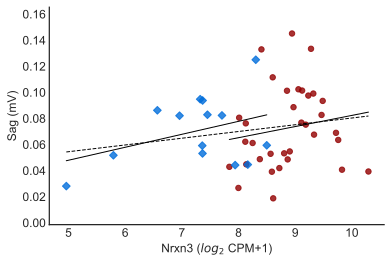

In [51]:
fig, ax = plt.subplots()
make_scatter(18191, 'sag', ax, df_seq, df_ephys, line_labels, unit = 'CPM')
plt.show()

# Fig 4
# Consistency between NE_inh & AIBS E~G vs E~G|C

In [37]:
measure_dict_ne = {'Rin' : 'ri', 
           'Vrest' : 'rmp', 
           'APthr' : 'apthr', 
           'APamp' : 'apamp', 
           'APhw' : 'aphw', 
           'Tau' : 'tau', 
           'AHPamp' : 'ahpamp', 
           'Rheo' : 'rheo',
           'FRmax' : 'maxfreq', 
           'Cm' : 'cap',
           'SFA' : 'adratio'}


In [40]:
def analyze_consistency(res_old, res_new, bootstrap = False):
    
    # Relabel measures    
    measures = measure_dict_ne.values()
    res_old.ephys_measure = [measure_dict_ne[m] for m in res_old.ephys_measure]
    set1 = 'NE'
    set2 = 'AIBS'
    
    # Re-index to include only common genes
    genes_intersect = set(res_old.gene).intersection(set(res_new.gene_symbol))
    res_old = res_old[[gene in genes_intersect for gene in res_old.gene]]
    res_old.index = [res_old.ephys_measure, res_old.gene]
    res_new.index = [res_new.ephys_measure, res_new.gene_symbol]
    res_new = res_new.reindex(res_old.index)
    
#     res_new['E~G'] = np.copysign(np.log2(res_new.FDR_gene), res_new.beta_gene)
#     res_new['E~G|C'] = np.copysign(np.log2(res_new['FDR_gene|class_anova']), res_new['beta_gene|class'])
    res_new['E~G'] = res_new.beta_gene
    res_new['E~G|C'] = res_new['beta_gene|class']
    
    # Calculate overall correlations

    df_comparison = pd.DataFrame(index = [measure_dict[m] for m in measures], 
                                 columns = ['r (' + set1 + '_inh vs ' + set2 + '_E~G)',
                                            'p-value (' + set1 + '_inh vs ' + set2 + '_E~G)', 
                                            'r (' + set1 + '_inh vs ' + set2 + '_E~G|C)', 
                                            'p-value (' + set1 + '_inh vs ' + set2 + '_E~G|C)'])

    if bootstrap:
        upper_bootstrap_list_list = []
        lower_bootstrap_list_list = []
        sig_list = []

    for measure in measures:
        if bootstrap:
            upper_bootstrap_list = []
            lower_bootstrap_list = []
            correlations_list = []
        for a in ['E~G', 'E~G|C']:
            x = res_old.loc[measure, :]['inh_r']
            y = res_new.loc[measure, :][a]
            r, p = stats.spearmanr(x, y, nan_policy = 'omit')
            df_comparison.loc[measure_dict[measure], 'p < 0.01 (' + set1 + '_inh vs ' + set2 + '_' + a + ')'] = '*' if p < 0.01 else ''
            if p == 0.0:
                p = '< 1e-300'
            df_comparison.loc[measure_dict[measure], 'r (' + set1 + '_inh vs ' + set2 + '_' + a + ')'] = round(r, 3)
            df_comparison.loc[measure_dict[measure], 'p-value (' + set1 + '_inh vs ' + set2 + '_' + a + ')'] = p
            
            # Bootstrap confidence intervals
            if bootstrap:
                tmp = np.array([x, y]).T
                length = tmp.shape[0]
                samples = 100
                correlations = []

                for n in range(samples):
                    resampled = tmp[randint(length, size = length)]
                    r = stats.spearmanr(resampled[:, 0], resampled[:, 1], nan_policy = 'omit')[0]
                    correlations.append(r)
                mean = np.mean(correlations)
                upper = np.percentile(correlations, 97.5) - mean
                lower = mean - np.percentile(correlations, 2.5)
                
                upper_bootstrap_list.append(upper)
                lower_bootstrap_list.append(lower)
                correlations_list.append(correlations)
        if bootstrap:
            upper_bootstrap_list_list.append(upper_bootstrap_list)            
            lower_bootstrap_list_list.append(lower_bootstrap_list)
            differences = [a - b for a, b in zip(correlations_list[0], correlations_list[1])]
            upper = np.percentile(differences, 97.5)
            lower = np.percentile(differences, 2.5)
            if np.sign(upper) == np.sign(lower):
                sig_list.append('*')
            else:
                sig_list.append('')

    if bootstrap:
        df_upper = pd.DataFrame(upper_bootstrap_list_list, index = [measure_dict[m] for m in measures], columns = ['inh vs reg', 'inh vs par'])
        df_lower = pd.DataFrame(lower_bootstrap_list_list, index = [measure_dict[m] for m in measures], columns = ['inh vs reg', 'inh vs par'])
        df_sig = pd.DataFrame(sig_list, index = [measure_dict[m] for m in measures], columns = ['p < 0.05'])
        return df_comparison, res_old, res_new, df_upper, df_lower, df_sig
    else:
        return df_comparison, res_old, res_new

In [41]:
analysis_folder1 = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/Test/'
analysis_folder2 = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-07-19 Neuroelectro Neuroexpresso/'

res_old = pd.read_csv(analysis_folder2 + 'rpq_all_genes_nonprojecting_exclude_Htr3a_Oxtr.csv', index_col = 0)
res_new = res.copy()
# Older version of this function calculated error bars but not significance
# df_comparison, res_old, res_new, df_upper, df_lower = analyze_consistency(res_old, res_new, comparison_type = 'NE', bootstrap = True)

# With bootstrapping step - run once and then save since it takes some time to run
# df_comparison, res_old, res_new, df_upper, df_lower, df_sig = analyze_consistency(res_old, res_new, 
#                                                                                   bootstrap = True)

# No bootstrap
df_comparison, res_old, res_new = analyze_consistency(res_old, res_new, bootstrap = False)


In [42]:
# Older version - does not include significance

# df_upper.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-28 Bootstrap confidence intervals/error_upper.csv')
# df_lower.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-28 Bootstrap confidence intervals/error_lower.csv')

In [43]:
# Version for paper

# df_upper.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-12-04 Bootstrap confidence intervals/error_upper.csv')
# df_lower.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-12-04 Bootstrap confidence intervals/error_lower.csv')
# df_sig.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-12-04 Bootstrap confidence intervals/significance.csv')

In [44]:
df_upper = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-12-04 Bootstrap confidence intervals/error_upper.csv', index_col = 0)
df_lower = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-12-04 Bootstrap confidence intervals/error_lower.csv', index_col = 0)
df_sig = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-12-04 Bootstrap confidence intervals/significance.csv', index_col = 0).fillna('')

In [45]:
# Calculate whether at least one model has a positive consistency metric (including CIs)

bootstrap_above_zero = []
for m in df_comparison.index:
    r_ind = df_comparison.loc[m, 'r (NE_inh vs AIBS_E~G)']
    r_cond = df_comparison.loc[m, 'r (NE_inh vs AIBS_E~G|C)']
    interval_ind = (r_ind - df_lower.loc[m, 'inh vs reg'], r_ind + df_upper.loc[m, 'inh vs reg'])
    interval_cond = (r_cond - df_lower.loc[m, 'inh vs par'], r_cond + df_upper.loc[m, 'inh vs par'])
    if (interval_ind[0] > 0) or (interval_cond[0] > 0):
        bootstrap_above_zero.append(True)
    else:
        bootstrap_above_zero.append(False)

df_comparison['Above_zero'] = bootstrap_above_zero
df_comparison['Significant'] = df_sig.values

In [46]:
df_comparison

,r (NE_inh vs AIBS_E~G),p-value (NE_inh vs AIBS_E~G),r (NE_inh vs AIBS_E~G|C),p-value (NE_inh vs AIBS_E~G|C),p < 0.01 (NE_inh vs AIBS_E~G),p < 0.01 (NE_inh vs AIBS_E~G|C),Above_zero,Significant
AP Half-width,0.175,6.76661582886e-55,0.277,1.11675162952e-137,*,*,True,*
AHP Amplitude,-0.188,3.77764681958e-63,-0.116,4.55814840492e-25,*,*,False,*
Max Firing Frequency,0.072,2.34304708245e-10,0.165,1.19245269546e-48,*,*,True,*
Rheobase,0.285,1.2976214215e-146,0.296,7.2848856671e-158,*,*,True,
AP Threshold,-0.033,0.00339110649236,-0.12,1.82678663623e-26,*,*,False,*
AP Amplitude,-0.047,3.42205592777e-05,0.075,2.32468903878e-11,*,*,True,*
Time Constant Tau,0.31,6.25923694114e-174,0.249,2.64435438535e-111,*,*,True,*
Capacitance,0.059,1.681992126e-07,-0.026,0.0199513490387,*,,True,*
Input Resistance,0.305,2.34021763715e-168,0.35,2.05201894154e-224,*,*,True,*
Resting Membrane Potential,0.055,9.20149606168e-07,0.227,1.87874521633e-92,*,*,True,*


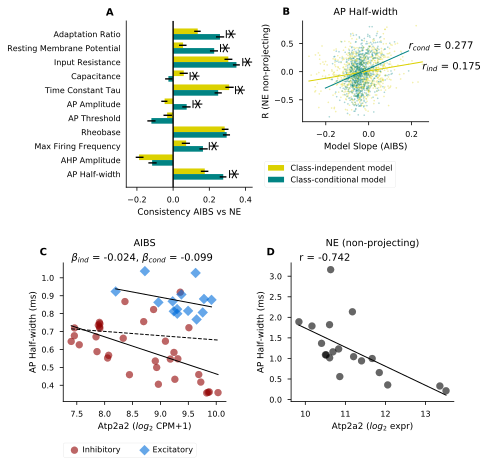

In [49]:
%config InlineBackend.figure_format = 'svg'
# NE vs AIBS

df = df_comparison

fig = plt.figure(figsize = (7, 7), dpi = 150)

gs1 = GridSpec(2, 2, height_ratios = [2, 1])
gs2 = GridSpec(1, 2)
gs1.update(left = 0.25, right = 0.85, bottom = 0.55, wspace = 0.4)
gs2.update(top = 0.4, wspace = 0.4)
axes_list = []

width = 0.4
ax = plt.subplot(gs1[:, 0])
axes_list.append(ax)
ind = np.arange(len(df.index))
ax.barh(ind + width, df['r (NE_inh vs AIBS_E~G)'], xerr = [df_lower['inh vs reg'], df_upper['inh vs reg']],
        height = width, color = color_reg, label = 'Class-independent model')
ax.barh(ind, df['r (NE_inh vs AIBS_E~G|C)'], xerr = [df_lower['inh vs par'], df_upper['inh vs par']], 
        height = width, color = color_par, label = 'Class-conditional model')
xlim = ax.get_xlim()
ax.set_xlim(xlim[0] * 1.1, xlim[1] * 1.1)
ylim = ax.get_ylim()
ax.plot([0, 0], ylim, 'k-')
ax.set_ylim(ylim)
ax.set_yticks(ind + (0.5 * width))
ax.set_yticklabels(df.index, rotation = 0, ha = 'right')
ax.set_xlabel('Consistency AIBS vs NE')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis = 'y', length=0, width=0)
ax.legend(loc = 'lower left', bbox_to_anchor = (1.1, 0), borderaxespad = 0)

for i, measure in zip(ind, df_comparison.index):
    star = df_comparison.loc[measure, 'Significant']
    above_zero = df_comparison.loc[measure, 'Above_zero']
    ypos = max([df_comparison.loc[measure, 'r (NE_inh vs AIBS_E~G)'],
                df_comparison.loc[measure, 'r (NE_inh vs AIBS_E~G|C)']]) + 0.035
    if above_zero & (star == '*'):
        ax.annotate(star, (ypos, i + (0.5 * width)), 
            ha = 'center', va = 'center', fontsize = 20, rotation = 270)
        ax.annotate('', (ypos, i - (0.5 * width)), (ypos, i + (1.5 * width)), arrowprops=dict(arrowstyle = '-', linewidth = 1))


        
measure = 'aphw'        

ax = plt.subplot(gs1[0, 1])
axes_list.append(ax)
for xpos, var_x, label1, label2, label3, color in zip([1, 2], ['beta_gene', 'beta_gene|class'], ['Class-independent\nmodel slope', 'Class-conditional\nmodel slope'], ['_reg', '_par'], ['ind', 'cond'], [color_reg, color_par]):
    x = res_new[res_new.ephys_measure == measure][var_x]
    y = res_old[res_old.ephys_measure == measure]['inh_r']
    xy = pd.DataFrame([x, y], index = ['x', 'y']).dropna(axis = 1)
    fit = np.polyfit(xy.loc['x'], xy.loc['y'], deg = 1)
    r = round(stats.spearmanr(list(xy.loc['x'].values), list(xy.loc['y'].values))[0], 3)
    xy = xy.sample(frac = 0.1, axis = 1)
    lim = pd.Series([min(list(xy.loc['x'].values)), max(list(xy.loc['x'].values))])
    
    ax.scatter(xy.loc['x'], xy.loc['y'], alpha = 0.3, s = 2, color = color)

    ax.plot(lim, lim * fit[0] + fit[1], '-', color = color, linewidth = 1)
    ax.annotate(r'$r_{' + label3 + '}$ = ' + str(r), (lim[1], lim[1] * fit[0] + fit[1]), va = 'top' if var_x == 'beta_gene' else 'bottom')
    ax.set_xlabel('Model Slope (AIBS)')
    ax.set_ylabel('R (NE non-projecting)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    ax.set_title(measure_dict[measure])
    
        
gene = 'Atp2a2'
gene_id = 11938

# AIBS data
ax = plt.subplot(gs2[0, 0])
axes_list.append(ax)
make_scatter(gene_id, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
             line_labels = line_labels, unit = 'CPM', s = 50)
a1 = r'$\beta_{ind}$ = ' + str(round(res[(res.gene_entrez_id == gene_id) & 
                                                        (res.ephys_measure == measure)]['beta_gene'].values[0], 3))
a2 = r'$\beta_{cond}$ = ' + str(round(res[(res.gene_entrez_id == gene_id) & 
                                                        (res.ephys_measure == measure)]['beta_gene|class'].values[0], 3))

ax.annotate(a1 + ', ' + a2, (0.05, 1), xycoords = 'axes fraction', ha = 'left', va = 'bottom')

# NE data
ax = plt.subplot(gs2[0, 1])
axes_list.append(ax)
x = ne_inh[gene]
y = ne_inh['APhw']
ax.scatter(x, y, s = 50, alpha = 0.6, c = 'black')
idx = np.isfinite(x) & np.isfinite(y)
if len(x[idx]) > 1:
    fit = np.polyfit(x[idx], y[idx], deg = 1)
    lim = pd.Series([x[idx].min(), x[idx].max()])
    ax.plot(lim, lim * fit[0] + fit[1], '-', linewidth = 1, color = 'black')
    r = round(stats.spearmanr(x, y, nan_policy = 'omit')[0], 3)
ax.set_xlabel(gene + ' ($log_2$ expr)')
ax.set_ylabel(measure_dict[measure] + ' (ms)')
ax.annotate('r = ' + str(r), (0.05, 1), xycoords = 'axes fraction', 
        ha = 'left', va = 'bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

i = axes_list[2].scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = axes_list[2].scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes_list[2].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, -0.3), 
                    loc= 'upper left', frameon = True, ncol = 2, borderaxespad = 0, handletextpad = 0) 

axes_list[2].set_title('AIBS\n')
axes_list[3].set_title('NE (non-projecting)\n')

for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes_list):
    ax.annotate(letter, (-0.1, 1.02) if letter == 'A' else (-0.1, 1.04),
                ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.show()
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig4_draft15.png', bbox_inches = 'tight')
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig4_draft14.svg', bbox_inches = 'tight', dpi = 300)
# plt.clf()

# Fig 6
# VG Potassium channels - E~G vs E~G|C

In [606]:
# how many total genes for AHPamp at FDR < 0.01 versus 0.1?

# Since this is a property with lots of significant genes, makes sense to use a more stringent threshold than for some others
# If I didn't know anything about how this property were regulated I would probably be more interested in the 
    # FDR < 0.01 group than the FDR < 0.1.

print(res[(res.ephys_measure == 'ahpamp') & (res['FDR_gene|class_anova'] < 0.1)].shape[0])
print(res[(res.ephys_measure == 'ahpamp') & (res['FDR_gene|class_anova'] < 0.01)].shape[0])

6568
3206


In [607]:
# From Alexander et al. 2017

channel_list = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/targets_and_families.csv', index_col = 0)

In [608]:
genes_kch_list = list(channel_list[channel_list['Family name'] == 'Voltage-gated potassium channels']['Mouse Entrez Gene'].values)

In [609]:
r_kch_par = res[[str(gene) in genes_kch_list for gene in res.gene_entrez_id]][['gene_entrez_id', 'ephys_measure', 'beta_gene|class', 'FDR_gene|class_anova']]
r_kch_reg = res[[str(gene) in genes_kch_list for gene in res.gene_entrez_id]][['gene_entrez_id', 'ephys_measure', 'beta_gene', 'FDR_gene']]
r_kch_par.columns = ['gene', 'Measure', 'beta', 'FDR']
r_kch_reg.columns = ['gene', 'Measure', 'beta', 'FDR']
r_kch_par['corrtype'] = 'partial'
r_kch_reg['corrtype'] = 'regular'
kch_r_combined = pd.concat([r_kch_par, r_kch_reg])


In [610]:
kch_r_combined['Sig_Lvl'] = [0.01 if FDR < 0.01 else 0.05 if FDR < 0.05 else 0.1 if FDR < 0.1 else 'n.s.' for FDR in kch_r_combined.FDR]

In [611]:
kch_r_ahpamp = kch_r_combined[kch_r_combined.Measure == 'ahpamp']

In [612]:
kch_r_ahpamp = kch_r_ahpamp.sort_values('Sig_Lvl', ascending = False)

In [613]:
set(kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'partial') & 
                 (kch_r_ahpamp.Sig_Lvl == 0.05)]['gene']).intersection(set(kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'regular') & 
                                                                                        (kch_r_ahpamp.Sig_Lvl == 0.01)]['gene']))



{16492, 226922}

In [614]:
kch_beta = kch_r_ahpamp.pivot(index = 'gene', columns = 'corrtype', values = 'beta')
kch_sig = kch_r_ahpamp.pivot(index = 'gene', columns = 'corrtype', values = 'FDR')
kch_sig.columns = ['FDR_partial', 'FDR_regular']
kch_beta = pd.concat([kch_beta, kch_sig], axis = 1)

In [615]:
kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.Sig_Lvl == 0.01) & (kch_r_ahpamp.beta > 0)].shape

(11, 6)

In [ ]:
# VG Potassium channels with signficant interactions

fig, axes = plt.subplots(2, 3, figsize = (8, 6))

for gene, ax in zip(res[[str(gene) in genes_kch_list for gene in res.gene_entrez_id] &
                        (res.FDR_int_anova < 0.1) & 
                        (res.ephys_measure == 'ahpamp')]['gene_entrez_id'], axes.flat):
    make_scatter(gene, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 10)
plt.tight_layout()
plt.show()
    
    

In [619]:
%config InlineBackend.figure_format = 'svg'

import seaborn as sns

genes_plot = [16512, 170738, 268345]

measure = 'ahpamp'
rows = 2
cols = 3

fig = plt.figure(figsize = (7, 3.5))
gs = GridSpec(rows, cols, width_ratios = [1, 1, 2.5])
axes_list = []

# Schematic
img = mpimg.imread('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/AHPamp.png')
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.imshow(img, cmap = 'gray', interpolation = 'None')
axes_list.append(ax)

# Example genes
for gene, title, xpos, ypos in zip(genes_plot, ('Class-driven', 'Non-class-driven', 'Non-class-driven;\nsig. in both models'), (1, 0, 1), (0, 1, 1)):
    if xpos == 0:
        ax = plt.subplot(gs[ypos, xpos])
        ax_share = ax
    elif (xpos == 1) & (ypos == 0):
        ax = plt.subplot(gs[ypos, xpos])
    else:
        ax = plt.subplot(gs[ypos, xpos], sharey = ax_share)
    axes_list.append(ax)
    make_scatter(gene, measure, ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 15)
#     if (xpos == 1) & (ypos == 1): 
#         ax.set_ylabel('')
    ax.set_title(title)

# Summary scatter plot
palette = {'regular' : color_reg, 'partial' : color_par}
ax = plt.subplot(gs[:, 2])

xy0 = kch_beta[(kch_beta.FDR_partial < 0.01) & (kch_beta.FDR_regular < 0.01)]
xy1 = kch_beta[(kch_beta.FDR_partial < 0.01) & (kch_beta.FDR_regular >= 0.01)]
xy2 = kch_beta[(kch_beta.FDR_partial >= 0.01) & (kch_beta.FDR_regular < 0.01)]
xy3 = kch_beta[(kch_beta.FDR_partial >= 0.01) & (kch_beta.FDR_regular >= 0.01)]
s3 = ax.scatter(xy3.regular, xy3.partial, color = 'grey', s = 50, marker = 'o', alpha = 0.5)
s2 = ax.scatter(xy2.regular, xy2.partial, color = color_reg, s = 50, marker = '^', alpha = 0.5)
s1 = ax.scatter(xy1.regular, xy1.partial, color = color_par, s = 50, marker = 's', alpha = 0.5)
s0 = ax.scatter(xy0.regular, xy0.partial, color = color_shared, s = 50, marker = 'D', alpha = 0.5)

# plt.scatter(kch_beta.regular, kch_beta.partial, color = kch_sig.color, alpha = 0.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, '--', color = 'grey')
ax.plot([0, 0], ylim, 'k-')
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
for gene, marker in zip(genes_plot, ['^', 's', 'D']):
    xy_pos = (kch_beta.loc[gene].regular, kch_beta.loc[gene].partial)
    xytext = (kch_beta.loc[gene].regular - 0.01, kch_beta.loc[gene].partial + 0.07)
    ax.scatter(kch_beta.loc[gene].regular, kch_beta.loc[gene].partial, s = 50, marker = marker, 
               facecolors = 'none', edgecolors = 'black', linewidth = 1)
    ax.annotate(res[(res.gene_entrez_id == gene) & (res.ephys_measure == measure)]['gene_symbol'].values[0], 
                xy = xy_pos, xytext = xytext, 
                arrowprops=dict(facecolor='black', width = 1, headwidth = 1, shrink=0.05))

# sns.violinplot('corrtype', 'beta', data = kch_r_ahpamp, ax = ax, 
#                order = ['regular', 'partial'], palette = palette, inner = None, saturation = 1)
# sns.swarmplot('corrtype', 'beta', hue = 'Sig_Lvl', data = kch_r_ahpamp, color = 'black', ax = ax, 
#               order = ['regular', 'partial'], size = 4)
# sns.kdeplot(kch_r_ahpamp[kch_r_ahpamp.corrtype == 'partial']['beta'], color = color_par, label = 'Class-conditional model')
# sns.kdeplot(kch_r_ahpamp[kch_r_ahpamp.corrtype == 'regular']['beta'], color = color_reg, label = 'Class-independent model')
# plt.legend(bbox_to_anchor=(0.7, 1), loc=2)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title = 'Significant at:')

# ax.set_xticklabels(['Class-independent model', 'Class-conditional model'])
ax.set_xlabel('slope (class-independent)')
ax.set_ylabel('slope (class-conditional)')

ax.legend([s2, s1, s0, s3], ['FDR < 0.01 class-\nindependent only', 'FDR < 0.01 class-\nconditional only', 
                                      'FDR < 0.01\nboth models', 'n.s.'], 
          bbox_to_anchor = (1, 0), loc = 'lower right', frameon = True)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes_list.append(ax)    
        
    
gs.tight_layout(fig)

ax = axes_list[2]
i = ax.scatter([], [], color = color_inh, marker = 'o', s = 15, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 15, alpha = 0.6)
ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, 1.3), loc= 'lower left', frameon = True, fontsize = 10)



for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes_list):
    ax.annotate(letter, (-0.1, 1.05), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig6_draft12.png', bbox_inches = 'tight', dpi = 300)    
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig6_draft12.svg', bbox_inches = 'tight', dpi = 300)    
plt.clf()

# plt.show()

In [78]:
kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.beta < 0)].shape

(10, 6)

In [70]:
# Is the mean value for gene vs AHPamp for VGKC genes different between reg and par?

par_r_values = kch_r_ahpamp[kch_r_ahpamp.corrtype == 'partial']['beta']
reg_r_values = kch_r_ahpamp[kch_r_ahpamp.corrtype == 'regular']['beta']

for ds in [par_r_values, reg_r_values]:
    print('Mean: ' + str(ds.mean()))
    print(2**(abs(ds.mean()) * -1))
    print(stats.normaltest(ds)[1])

print(stats.mannwhitneyu(par_r_values, reg_r_values))

Mean: 0.0113466844234
0.992165925261
0.00124721706511
Mean: -0.00301350049187
0.997913380654
0.313354210261
MannwhitneyuResult(statistic=336.0, pvalue=0.095723755830053103)


In [722]:
reg_pos = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'regular') & (kch_r_ahpamp.beta > 0)]['gene'].values)
reg_neg = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'regular') & (kch_r_ahpamp.beta < 0)]['gene'].values)
par_pos = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.beta > 0)]['gene'].values)
par_neg = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.beta < 0)]['gene'].values)



In [723]:
both_pos = set(par_pos).intersection(set(reg_pos))
par_only_pos = set(par_pos).difference(set(reg_pos))
reg_only_pos = set(reg_pos).difference(set(par_pos))

both_neg = set(par_neg).intersection(set(reg_neg))
par_only_neg = set(par_neg).difference(set(reg_neg))
reg_only_neg = set(reg_neg).difference(set(par_neg))

In [805]:
print(len(reg_pos))
print(len(par_pos))
print(len(both_pos))
print(len(reg_neg))
print(len(par_neg))
print(len(both_neg))

8
11
6
9
1
0


# Fig 7, Table 2
# Example genes

In [53]:
# Get only significant gene/ephys combos

res_sig_gc = res[res['FDR_gene|class_anova'] < 0.1]
counts_gc = res_sig_gc.groupby('gene_entrez_id')['ephys_measure'].count()
res_sig_int = res[res['FDR_int_anova'] < 0.1]
counts_int = res_sig_int.groupby('gene_entrez_id')['ephys_measure'].count()

res_sig = pd.concat([res_sig_gc, res_sig_int])
res_sig.drop_duplicates(inplace = True)

In [54]:
# Add count of number of significant features for a given gene (0.1) as a column

counts_col_gc = []
counts_col_int = []
for gene in res_sig.gene_entrez_id:
    counts_col_gc.append(counts_gc[gene] if gene in counts_gc.index else 0)
    counts_col_int.append(counts_int[gene] if gene in counts_int.index else 0)
res_sig.loc[:, 'n_significant_0.1_g|c'] = counts_col_gc
res_sig.loc[:, 'n_significant_0.1_int'] = counts_col_int

# Tables S4 and S5 - beta, significance values

In [56]:
# rename "ephys measure" to "property" since this table includes morphology
# Save as supplementary table

res_relabeled = res.copy()
res_relabeled.rename({'ephys_measure' : 'property'}, axis = 1, inplace = True)
res_sig_relabeled = res_sig.copy()
res_sig_relabeled.rename({'ephys_measure' : 'property'}, axis = 1, inplace = True)

tables_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/'
# res_sig_relabeled.to_csv(tables_folder + 'TableS4.csv')
# res_relabeled.to_csv(tables_folder + 'TableS5.csv')

In [57]:
names_list = [id_to_name[gene] for gene in res_sig.gene_entrez_id]

res_sig.loc[:, 'gene_name'] = names_list

In [58]:
# Select only genes that are:
    # Significant (E~G|C)
    # not near significance using E~G
    # No interaction

res_top = res_sig[(res_sig['FDR_gene|class_anova'] < 0.1) & 
                  (res_sig['FDR_gene'] > 0.2) & 
                  (res_sig['FDR_int_anova'] > 0.2)]
 
res_top = res_top.sort_values('FDR_gene|class_anova')

In [59]:
res_select = pd.DataFrame(columns = res_top.columns)

# Select top 3 genes per property
for measure in measures_all:
    res_select = pd.concat([res_select, res_top[res_top.ephys_measure == measure].iloc[:3]])

# Add hand-selected genes to table & heatmap
genes = [16485, 20266, 66725, 19337, 70208, 260305, 208846]
measures = ['maxfreq', 'aphw', 'branchiness', 'ahpamp', 'ahpamp', 'aphw', 'aphw']

for gene, measure in zip(genes, measures):
    res_select = pd.concat([res_select, res_sig[(res_sig.gene_entrez_id == gene) & (res_sig.ephys_measure == measure)]])
    
# Make prettier version for Table 2
table2 = res_select[['ephys_measure',
                         'gene_symbol',
                         'gene_name',
                         'FDR_gene|class_anova',
                         'beta_gene|class']]

table2.loc[:, 'gene_symbol'] = [n + ('*' if n in [id_to_symbol[g] for g in genes] else '') for n in table2['gene_symbol']] 

table2.columns = ['Property', 'Gene', 'Gene Name', 'FDR', 'Slope']

properties = [measure_dict[m] for m in table2.Property]
table2.loc[:, 'Property'] = properties    

//anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [299]:
# table2.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/Table2_draft2.csv')

In [60]:
measures_hm = list(res_select.ephys_measure.unique())
genes_hm = res_select.gene_symbol

res_hm = res[[gene in genes_hm.values for gene in res.gene_symbol]]
res_hm = res_hm[[m in measures_hm for m in res_hm.ephys_measure]]

res_hm = res_hm.pivot('gene_symbol', 'ephys_measure', 'FDR_gene|class_anova')
res_hm.columns = [measure_dict[m] for m in res_hm.columns]
res_hm.index = [n + ('*' if n in [id_to_symbol[g] for g in genes] else '') for n in res_hm.index]    


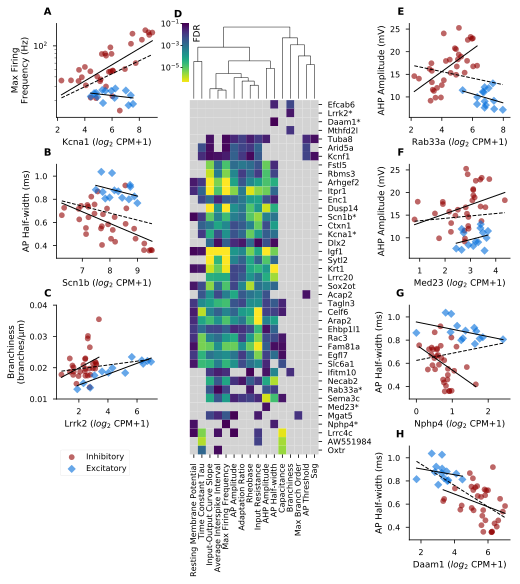

In [61]:
# Without filtering for specificity, directionless, log10
from matplotlib.colors import LogNorm
from __future__ import unicode_literals

genes = [16485, 20266, 66725, 19337, 70208, 260305, 208846]
measures = ['maxfreq', 'aphw', 'branchiness', 'ahpamp', 'ahpamp', 'aphw', 'aphw']


# fig = plt.figure(figsize = (7, 9.5), dpi = 100)
axes = []

cmap = matplotlib.cm.viridis_r
cmap.set_bad('lightgray',1.)
cbar_ticks = [1e-1, 1e-3, 1e-5]
c = sns.clustermap(res_hm, figsize = (7, 9.5), cmap = cmap, mask = res_hm >= 0.1, norm = LogNorm(vmin = res_hm.min(), vmax = 0.1), 
                   vmax = 0.1, cbar_kws = {'label' : '              FDR', 'ticks' : cbar_ticks}, 
                   robust = True, yticklabels = True)
c.ax_row_dendrogram.set_visible(False)
# c.ax_col_dendrogram.set_visible(False)
ax_hm = plt.gca()

# c = sns.heatmap(res_hm.T, linewidths = 0, rasterized = True,
#                 cbar_kws = {'orientation': 'vertical', 'ticks' :[0.1, 1e-3, 1e-5], 
#                             'label' : 'FDR class-conditional', 'extend' : 'max', 'pad' : 0.01, 'fraction' : 0.02}, 
#                 cmap = cmap, fmt = '', 
#                 norm = LogNorm(vmin = res_hm.T.min(), vmax = res_hm.T.max()),
#                 yticklabels = [measure_dict[n] for n in measures_hm], robust = True, vmax = 0.1)

# ax.set_xticks(np.arange(len(res_hm.index)))
# ax.set_xticklabels(res_hm.index, ha = 'left')
# plt.setp(ax_hm.yaxis.get_majorticklabels(), fontsize = 8)
# plt.setp(c.ax_heatmap.xaxis.get_majorticklabels(), fontsize = 8)
# plt.setp(c.ax_heatmap.yaxis.get_majorticklabels(), fontsize = 8)
# plt.setp(ax_hm.xaxis.get_majorticklabels(), fontsize = 10)



gs1 = GridSpec(4, 1, hspace = 0.5)
gs2 = c.gs
gs3 = GridSpec(4, 1, hspace = 0.5)
gs2.set_width_ratios([0.05, 0, 1])
ratios = gs2.get_height_ratios()
gs2.set_height_ratios([ratios[0] / 1.2, ratios[1] / 1.2, ratios[2]])
gs1.update(left = 0.1, right = 0.3)
gs2.update(left = 0.35, right = 0.62, bottom = 0.25)
gs3.update(left = 0.8, right = 1)

ax_hm.yaxis.set_ticks_position('left')
ax_hm.tick_params(axis = 'y', length=2)
ax_hm.yaxis.set_tick_params(pad=1)

axes = []

for gene, measure, ypos in zip(genes[:3], measures[:3], range(3)):
    ax = plt.subplot(gs1[ypos, 0])
    axes.append(ax)
    if measure == 'branchiness':
        make_scatter(gene, measure, ax, df_seq = df_seq_morph, df_ephys = df_morph, 
                     line_labels = line_labels_morph, unit = 'CPM', s = 30) 
        ax.set_ylim(0.01, 0.04)
    else:
        make_scatter(gene, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
                     line_labels = line_labels, unit = 'CPM', s = 30, log = True if measure == 'maxfreq' else False)

i = ax.scatter([], [], color = color_inh, marker = 'o', s = 30, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 30, alpha = 0.6)
ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, -0.5), loc= 'upper left', frameon = True)

axes.append(ax_hm)

genes = [19337, 70208, 260305, 208846]
measures = ['ahpamp', 'ahpamp', 'aphw', 'aphw']

for gene, measure, ypos in zip(genes, measures, range(4)):
    ax = plt.subplot(gs3[ypos, 0])
    axes.append(ax)
    make_scatter(gene, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
                     line_labels = line_labels, unit = 'CPM', s = 30)
    

for letter, ax in zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], axes):
    ax.annotate(letter, (-0.05, 1.07), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')        
    
# plt.show()
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig7_draft5.png', bbox_inches = 'tight', dpi = 300)    
# plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig7_draft1.svg', bbox_inches = 'tight', dpi = 300)    
# plt.clf()

# Table S1 - cell type definitions & counts

In [21]:
counts_ephys = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/Counts.csv', index_col = 0)
counts_morph = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-16/Counts.csv', index_col = 0)

counts_ephys.index = pd.MultiIndex.from_tuples([tuple(n.split('__')) for n in counts_ephys.index])
counts_morph.index = pd.MultiIndex.from_tuples([tuple(n.split('__')) for n in counts_morph.index])

counts_morph.columns = ['RNA_seq_duplicate', 'Morphology']
counts_combined = pd.concat([counts_ephys, counts_morph], axis = 1)
counts_combined.RNA_seq = counts_combined.RNA_seq.combine_first(counts_combined.RNA_seq_duplicate)
counts_combined.drop(['RNA_seq_duplicate'], axis = 1, inplace = True)

count_cells = counts_combined.sum(axis = 0)
count_types = counts_combined.count(axis = 0)

counts_combined.loc[('Number of Cells', '', '')] = count_cells
counts_combined.loc[('Number of Types', '', '')] = count_types

# counts_combined.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS1.csv')

# AIC plots

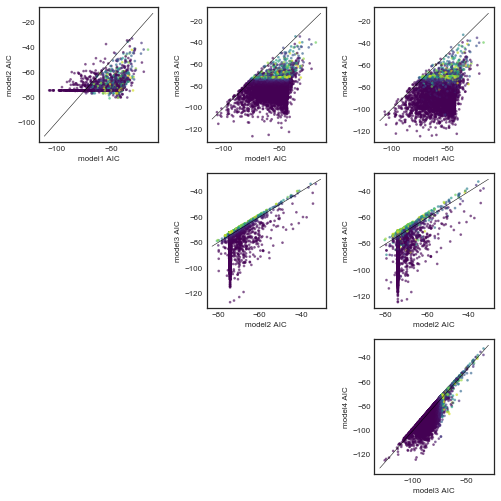

In [501]:
fig, axes = plt.subplots(3, 3, figsize = (7, 7))

df = res[res.ephys_measure == 'ahpamp']

for ypos, x in enumerate(['model1', 'model2', 'model3']):
    for xpos, y, c in zip(range(3), ['model2', 'model3', 'model4'], ['pval_gene', 'pval_gene|class_anova', 'pval_int_anova']):
        ax = axes[ypos, xpos]
        if (x != y) & (xpos >= ypos):
            s = ax.scatter(df[x + '_aic'], df[y + '_aic'], c = df['pval_gene|class_anova'], cmap = 'viridis', s = 3, alpha = 0.5)
            ax.set_xlabel(x + ' AIC')
            ax.set_ylabel(y + ' AIC')
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], '-', color = 'black', linewidth = 0.5)
        else:
            ax.axis('off')

# plt.colorbar(s)
plt.tight_layout()
plt.show()

# Interactions and EI balance
cool idea but didn't work

We wanted to see whether genes with a known association with epilepsy would be more likely to show a significant interaction for properties like maximum frequency or F/I curve slope. This would make sense, since differentially regulating these properties in different classes might make perturbing them more likely to shift E/I balance. This didn't really pan out, which I think it just attributable to things like circuit effects, indirect regulation of firing frequency, biology is complicated, etc.

Epilepsy gene lists from:  
http://www.wzgenomics.cn/EpilepsyGene/download.php  
https://erminej.msl.ubc.ca/help/input-files/gene-sets/

In [145]:
fi = res[(res.ephys_measure == 'f_i_curve_slope') & 
    (res.FDR_int_anova < 0.1) & 
    (res.slope_inh > res.slope_exc)]['gene_entrez_id'].values

mf = res[(res.ephys_measure == 'maxfreq') & 
    (res.FDR_int_anova < 0.1) & 
    (res.slope_inh > res.slope_exc)]['gene_entrez_id'].values



In [146]:
len(fi)

320

In [147]:
len(mf)

254

In [150]:
fi_mf = list(set(fi).union(set(mf)))

In [151]:
len(fi_mf)

349

In [153]:
fi_mf_names = [id_to_symbol[n] for n in fi_mf]

In [159]:
'Scn1a' in fi_mf_names

True

In [179]:
epilepsy = []

with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Phenocarta_ErmineJ_mouseGenesets.tsv', 'r') as f:
    for line in f:
        l = line.strip().split('\t')
        if len(l) > 2:
            if 'epilepsy' in str(l[1]):
                epilepsy = epilepsy + l[2:]

epilepsy = [str(n) for n in epilepsy]

In [309]:
epilepsy_specific = []
epilepsy_labels = []

with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Phenocarta_ErmineJ_mouseGenesets.tsv', 'r') as f:
    for line in f:
        l = line.strip().split('\t')
        if len(l) > 2:
            if 'epilepsy' in str(l[1]):
                epilepsy_specific.append([str(n) for n in l[2:]])
                epilepsy_labels.append(str(l[1]))



In [181]:
set(fi_mf_names).intersection(set(epilepsy))

{'Cacna1a',
 'Cntnap4',
 'Hrh3',
 'Kcnq3',
 'Phlda1',
 'Plat',
 'Scn1a',
 'Sparcl1',
 'Vdac2',
 'Vegfa'}

In [182]:
len(fi_mf_names)

349

In [186]:
epilepsy2 = pd.read_table('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/high-confidence-gene.xls')

epilepsy2.columns = ['Category',
 'Gene_symbol',
 'Number of mutations',
 'Score',
 'Related phenotpes']

In [189]:
# gene_map = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Transcription_Factors/all_genes_human_mouse.csv', index_col = 0)

# m_to_h = {}
# h_to_m = {}
# for hgene in gene_map.index:
#     mgene = gene_map.loc[hgene].values[0]
#     if isinstance(mgene, np.ndarray):
#         mgene = mgene[0]
#     if isinstance(mgene, str) and isinstance(hgene, str):
#         m_to_h[mgene] = hgene
#         h_to_m[hgene] = mgene

In [207]:
epilepsy2['gene_symbol_mouse'] = [h_to_m[n] if n in h_to_m.keys() else np.nan for n in epilepsy2.Gene_symbol]

In [213]:
epilepsy2.dropna(inplace = True)

In [295]:
epilepsy_all = set(epilepsy2['gene_symbol_mouse']).union(epilepsy)

In [296]:
len(epilepsy_all)

594

In [334]:
set(fi_mf_names).intersection(set(epilepsy))

{'Cacna1a',
 'Cntnap4',
 'Hrh3',
 'Kcnq3',
 'Phlda1',
 'Plat',
 'Scn1a',
 'Sparcl1',
 'Vdac2',
 'Vegfa'}

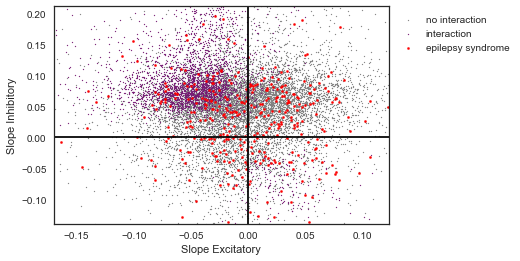

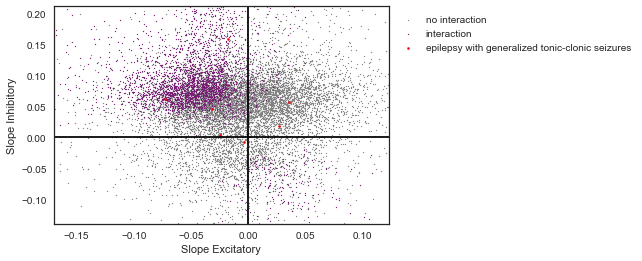

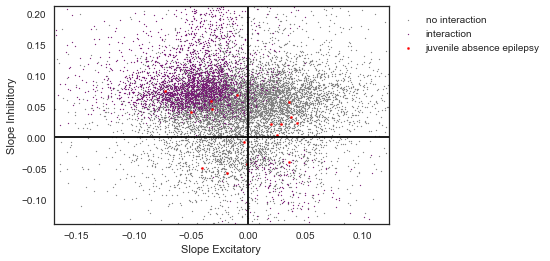

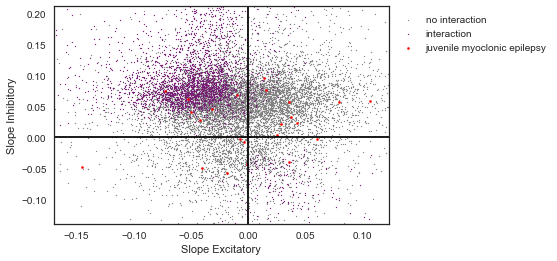

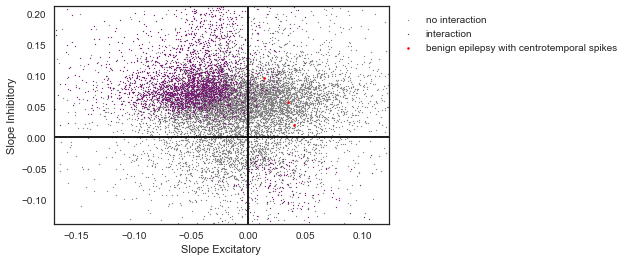

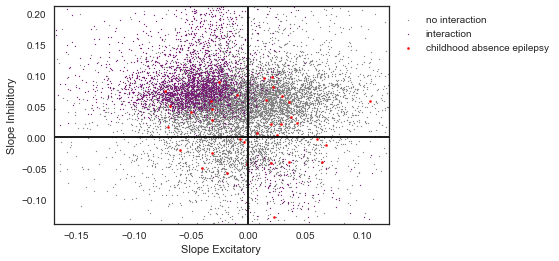

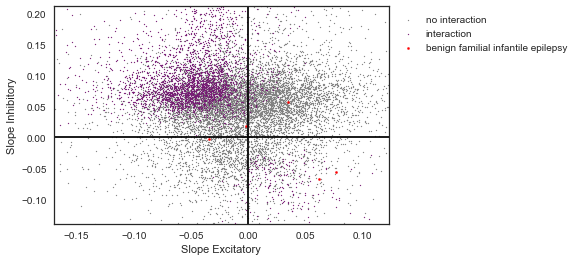

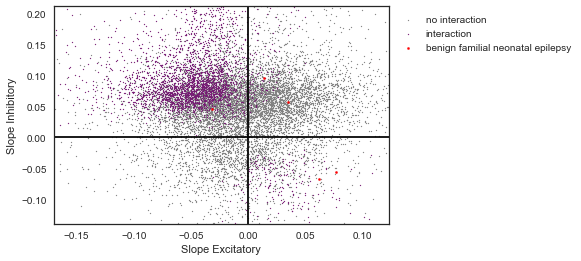

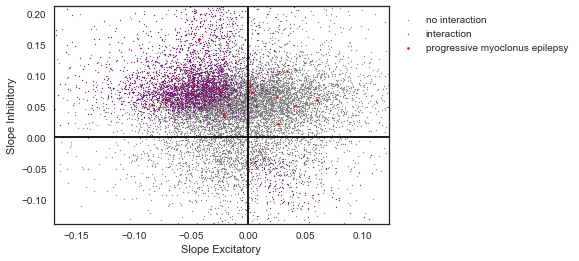

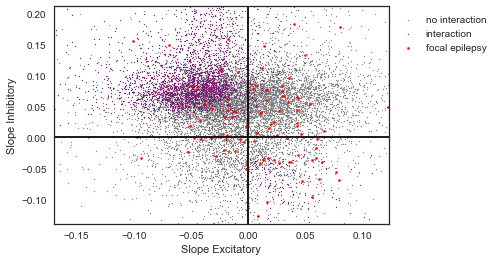

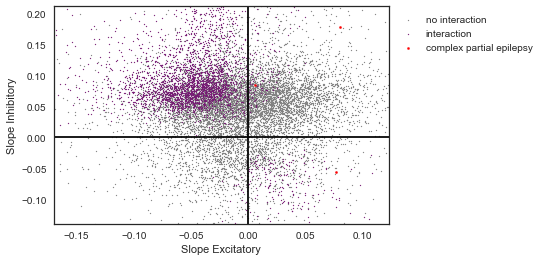

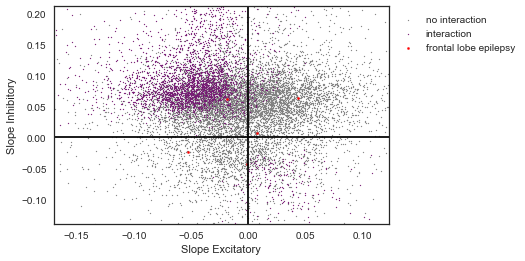

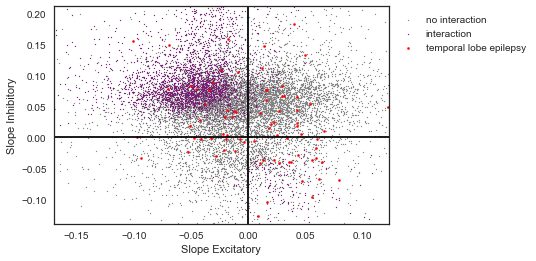

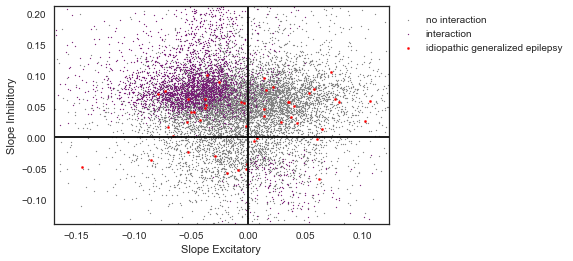

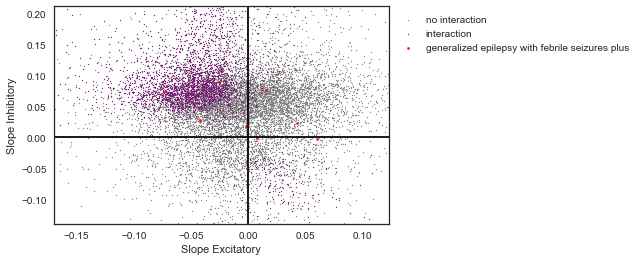

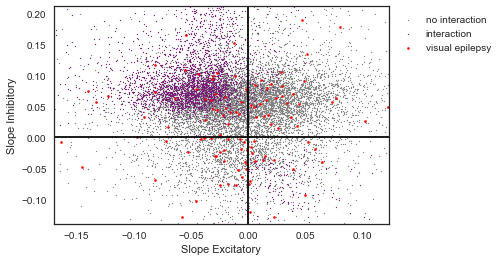

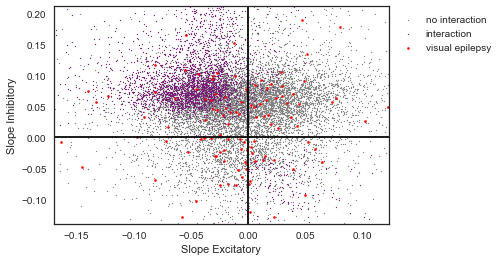

In [337]:
for label, epgenes in zip(epilepsy_labels, epilepsy_specific):
    fig, ax = plt.subplots()

    measure = 'f_i_curve_slope'
    res_subset = res[res.ephys_measure == measure]
    xy_genes = subset['gene_symbol']
    x = subset['slope_exc']
    y = subset['slope_inh']
    z = subset['FDR_int_anova']
    xy = pd.DataFrame([xy_genes, x, y, z], index = ['gene_symbol', 'x', 'y', 'z']).T
    xy.dropna(inplace = True)
    xy1 = xy[xy.z < 0.1]
    xy2 = xy[xy.z >= 0.1]
    s2 = ax.scatter(xy2.x, xy2.y, color = 'grey', s = 1, alpha = 1, label = 'no interaction')
    s1 = ax.scatter(xy1.x, xy1.y, color = color_int, s = 1, alpha = 1, label = 'interaction')
    xy['epilepsy'] = [1 if n in epgenes else 0 for n in xy.gene_symbol]
    xy_epilepsy = xy[xy.epilepsy == 1]
    s0 = ax.scatter(xy_epilepsy.x, xy_epilepsy.y, color = 'red', s = 5, alpha = 1, label = label)
    xlim = np.percentile(xy.x, 1), np.percentile(xy.x, 99)
    ylim = np.percentile(xy.y, 1), np.percentile(xy.y, 99)
    ax.plot([0, 0], ylim, color = 'black')
    ax.plot(xlim, [0, 0], color = 'black')
    ax.set_xlim(xlim)fig 
    ax.set_ylim(ylim)
    ax.set_xlabel('Slope Excitatory')
    ax.set_ylabel('Slope Inhibitory')
    plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

    plt.show()

# Get beta SEM values for selected genes

In [857]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# fit linear models explaining ephys according to gene expression and/or cell class
# returns a summary dataframe containing beta values, class-specific slopes, and p-values

def fit_models(df_seq, df_var2, line_labels, genes, measures, zero_threshold = 2, min_samples = 10):
    
    result_list = []
    result_dict = {}
        
    line_labels = pd.DataFrame([{1 : 'exc', 0 : 'inh'}[n] for n in line_labels], index = df_var2.columns, columns = ['cell_class'])
    
    # For each combination of gene and measure, pull out data into x and y variables
    for n, measure in enumerate(measures):
        for m, gene in enumerate(genes):
            if (gene in df_seq.index) & ((df_seq.loc[gene] > 1).sum() >= min_samples):
                x = df_seq.loc[gene, :]
                y = df_var2.loc[measure, :]
                
                # If shapes of x and y make sense, create models
                if x.shape == (df_var2.shape[1],) and y.shape == (df_var2.shape[1],):
                                  
                    # Remove all zero values if there are more than the specified threshold value                
                    not_zero = [val > 0 for val in x]
                    if not_zero.count(False) >= zero_threshold:
                        x = x[not_zero]
                        y = y[not_zero]
                        line_labels_gene = line_labels[not_zero]
                    else:
                        line_labels_gene = line_labels
                    
                    if not_zero.count(True) >= min_samples:

                        # Make a data frame with x and y data plus cell class
                        df_int = pd.concat([x, y, line_labels_gene], axis = 1)
                        gene_idx = 'Gene' + str(gene)
                        df_int.rename(columns = {gene: gene_idx}, inplace = True)

                        # Calculate models
                        mod1 = smf.ols(formula = measure + ' ~ ' + ' +  ' + gene_idx, data = df_int)
                        res1 = mod1.fit()
                        
                        # run class-based models only if both cell types present
                        if set(df_int['cell_class']) == {'exc', 'inh'}:
                            mod2 = smf.ols(formula = measure + ' ~ ' + 'C(cell_class)', data = df_int)
                            mod3 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class)', data = df_int)
                            mod4 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class) + ' + gene_idx + ' * C(cell_class)', data = df_int)
                            res2 = mod2.fit()
                            res3 = mod3.fit()
                            res4 = mod4.fit()

                            a1 = anova_lm(res2, res3)
                            a2 = anova_lm(res3, res4)
                            
                            result_dict[(gene, measure, 'class-independent')] = res1
                            result_dict[(gene, measure, 'class-conditional')] = res3
                            
                            results = [measure, gene, 
                                       res1.params[gene_idx], res3.params[gene_idx],  
                                       res4.params[gene_idx], res4.params[gene_idx] + res4.params[gene_idx + ':C(cell_class)[T.inh]'], 
                                       res1.pvalues[gene_idx], a1.loc[1, 'Pr(>F)'], a2.loc[1, 'Pr(>F)'], 
                                       res1.aic, res2.aic, res3.aic, res4.aic]
                        else:
                            results = [measure, gene, 
                                       res1.params[gene_idx], np.nan, 
                                       np.nan, np.nan, 
                                       res1.pvalues[gene_idx], np.nan, np.nan, 
                                       res1.aic, np.nan, np.nan, np.nan]
                                                
                        result_list.append(results)
                    
    # Convert to dataframe
    df = pd.DataFrame(result_list, columns = ['ephys_measure', 'gene_entrez_id', 
                                              'beta_gene', 'beta_gene|class', 
                                              'slope_exc', 'slope_inh', 
                                              'pval_gene', 'pval_gene|class_anova', 'pval_int_anova', 
                                              'model1_aic', 'model2_aic', 'model3_aic', 'model4_aic'])
    return df, result_dict

In [858]:
# Genes: Atp2a2, Kcna1, Fxyd6

df_test, result_dict = fit_models(df_seq, df_ephys, line_labels, 
                                  [11938, 16485, 59095], ['aphw', 'ahpamp_log10'])

In [859]:
df_test

,ephys_measure,gene_entrez_id,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic
0,aphw,11938,-0.023732,-0.098518,-0.058541,-0.103483,0.491449,1.293564e-04,0.555174,-23.763433,-52.592272,-66.389890,-64.774005
1,aphw,16485,-0.045175,-0.048462,0.014102,-0.057762,0.007542,5.276064e-05,0.024403,-30.793880,-52.592272,-68.217014,-71.805803
2,aphw,59095,0.022799,0.023973,0.009374,0.025428,0.001549,1.710677e-06,0.295296,-33.831164,-52.592272,-75.274944,-74.483460
3,ahpamp_log10,11938,0.031930,0.096227,0.070009,0.099484,0.253287,8.632858e-07,0.589733,-44.399389,-74.173752,-98.274318,-96.595135
4,ahpamp_log10,16485,0.031810,0.034535,-0.014140,0.041770,0.022147,4.090490e-04,0.036492,-48.543613,-74.173752,-85.642158,-88.467834
5,ahpamp_log10,59095,-0.019824,-0.020801,-0.008666,-0.022011,0.000649,8.655730e-08,0.244522,-55.287173,-74.173752,-103.060426,-102.554718


In [868]:
res_ind = result_dict[(59095, u'ahpamp_log10', u'class-conditional')]
res_ind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ahpamp_log10   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     59.44
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           2.35e-13
Time:                        19:29:04   Log-Likelihood:                 54.530
No. Observations:                  48   AIC:                            -103.1
Df Residuals:                      45   BIC:                            -97.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1180      0.030     37.322      0.000       1.058       1.178
C(cell_class)[T.inh]     0.2308      0.025      9.051      0.000       0.179       0.282
Gene59095               -0.0208      0.003     -6.375      0.000      -0.027      -0.014
==============================================================================
Omnibus:                        0.623   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.724
Skew:                           0.236   Prob(JB):                        0.696
Kurtosis:                       2.626   Cond. No.                         23.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""